<div align="center">
<h1><img width="30" src="https://madewithml.com/static/images/rounded_logo.png">&nbsp;<a href="https://madewithml.com/">Made With ML</a></h1>
    <h3>ML for Developers</h3>
    Design · Develop · Deploy · Iterate
</div>

<br>

<div align="center">
    <a target="_blank" href="https://madewithml.com"><img src="https://img.shields.io/badge/Subscribe-40K-brightgreen"></a>&nbsp;
    <a target="_blank" href="https://github.com/GokuMohandas/MadeWithML"><img src="https://img.shields.io/github/stars/GokuMohandas/MadeWithML.svg?style=social&label=Star"></a>&nbsp;
    <a target="_blank" href="https://www.linkedin.com/in/goku"><img src="https://img.shields.io/badge/style--5eba00.svg?label=LinkedIn&logo=linkedin&style=social"></a>&nbsp;
    <a target="_blank" href="https://twitter.com/GokuMohandas"><img src="https://img.shields.io/twitter/follow/GokuMohandas.svg?label=Follow&style=social"></a>
    <br>
    🔥&nbsp; Among the <a href="https://github.com/GokuMohandas/MadeWithML" target="_blank">top ML</a> repositories on GitHub
</div>

<br>
<hr>

This notebooks contains the code for the 🔢&nbsp; Data and 📈&nbsp; Modeling lessons. After this proof of concept (PoC), we'll be moving all of this code to Python scripts to serve our application to production. Follow the accompanying [lessons](https://madewithml.com/) along with the code here to develop a deeper understanding of all the concepts.

<div align="left">
<a target="_blank" href="https://madewithml.com/"><img src="https://img.shields.io/badge/📖 Read-lessons-9cf"></a>&nbsp;
<a href="https://github.com/GokuMohandas/Made-With-ML/blob/main/notebooks/madewithml.ipynb" role="button"><img src="https://img.shields.io/static/v1?label=&amp;message=View%20On%20GitHub&amp;color=586069&amp;logo=github&amp;labelColor=2f363d"></a>&nbsp;
<a href="https://colab.research.google.com/github/GokuMohandas/Made-With-ML/blob/main/notebooks/madewithml.ipynb"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"></a>
</div>

# 🛠️&nbsp; Setup

We'll be using [Ray](https://ray.io) to develop our application using distributed workloads.

In [1]:
import ray

In [2]:
# Initialize Ray
if ray.is_initialized():
    ray.shutdown()
ray.init()

2023-08-03 19:28:27,534	INFO worker.py:1612 -- Started a local Ray instance. View the dashboard at http://127.0.0.1:8265 


Python version:,3.11.4
Ray version:,2.6.0
Dashboard:,http://127.0.0.1:8265


In [3]:
ray.cluster_resources()

{'memory': 7677804544.0,
 'node:127.0.0.1': 1.0,
 'object_store_memory': 2147483648.0,
 'node:__internal_head__': 1.0,
 'CPU': 10.0}

These cluster resources only reflect our head node ([m5.2xlarge](https://instances.vantage.sh/aws/ec2/m5.2xlarge)). But recall in our [setup lesson](https://madewithml.com/courses/mlops/setup/) that our [compute configuration](https://madewithml.com/courses/mlops/setup/#compute) that we also added [g4dn.xlarge](https://instances.vantage.sh/aws/ec2/g4dn.xlarge) worker nodes (each has 1 GPU and 4 CPU) to our cluster. But because we set `min_workers=0`, our worker nodes will autoscale ( up to `max_workers`) as they're needed for specific workloads (ex. training). 

In [4]:
# Workers (1 g4dn.xlarge)

num_workers = 6
resources_per_worker={"CPU": 1, "GPU": 0}

If you are running this on a local laptop (no GPU), use the CPU count from `ray.cluster_resources()` to set your resources. For example if your machine has 10 CPUs:

```python
num_workers = 6  # prefer to do a few less than total available CPU (1 for head node + 1 for background tasks)
resources_per_worker={"CPU": 1, "GPU": 0}
```

# Data

## 🔢&nbsp; Data ingestion

In [5]:
import pandas as pd

In [6]:
# Data ingestion
DATASET_LOC = "https://raw.githubusercontent.com/GokuMohandas/Made-With-ML/main/datasets/dataset.csv"
df = pd.read_csv(DATASET_LOC)
df.head()

,id,created_on,title,description,tag
0,6,2020-02-20 06:43:18,Comparison between YOLO and RCNN on real world...,Bringing theory to experiment is cool. We can ...,computer-vision
1,7,2020-02-20 06:47:21,"Show, Infer & Tell: Contextual Inference for C...",The beauty of the work lies in the way it arch...,computer-vision
2,9,2020-02-24 16:24:45,Awesome Graph Classification,"A collection of important graph embedding, cla...",graph-learning
3,15,2020-02-28 23:55:26,Awesome Monte Carlo Tree Search,A curated list of Monte Carlo tree search pape...,reinforcement-learning
4,25,2020-03-07 23:04:31,AttentionWalk,"A PyTorch Implementation of ""Watch Your Step: ...",graph-learning


## ✂️&nbsp; Data splitting

In [10]:
from sklearn.model_selection import train_test_split

In [11]:
# Value counts
df.tag.value_counts()

tag
natural-language-processing    310
computer-vision                285
mlops                           63
reinforcement-learning          45
graph-learning                  33
time-series                     28
Name: count, dtype: int64

In [12]:
# Split dataset
test_size = 0.2
train_df, val_df = train_test_split(df, stratify=df.tag, test_size=test_size, random_state=1234)

In [15]:
# Train value counts
train_df.tag.value_counts()

tag
natural-language-processing    248
computer-vision                228
mlops                           50
reinforcement-learning          36
graph-learning                  26
time-series                     23
Name: count, dtype: int64

In [16]:
int((1-test_size) / test_size)

4

In [17]:
# Validation (adjusted) value counts
val_df.tag.value_counts() * int((1-test_size) / test_size)

tag
natural-language-processing    248
computer-vision                228
mlops                           52
reinforcement-learning          36
graph-learning                  28
time-series                     20
Name: count, dtype: int64

## 🔍&nbsp; Exploratory Data Analysis (EDA)

Exploratory data analysis to understand the signals and nuances of our dataset. It's a cyclical process that can be done at various points of our development process (before/after labeling, preprocessing, etc.) depending on how well the problem is defined.

In [18]:
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns; sns.set_theme()
import warnings; warnings.filterwarnings("ignore")
from wordcloud import WordCloud, STOPWORDS

In [19]:
# Most common tags
all_tags = Counter(df.tag)
all_tags.most_common()

[('natural-language-processing', 310),
 ('computer-vision', 285),
 ('mlops', 63),
 ('reinforcement-learning', 45),
 ('graph-learning', 33),
 ('time-series', 28)]

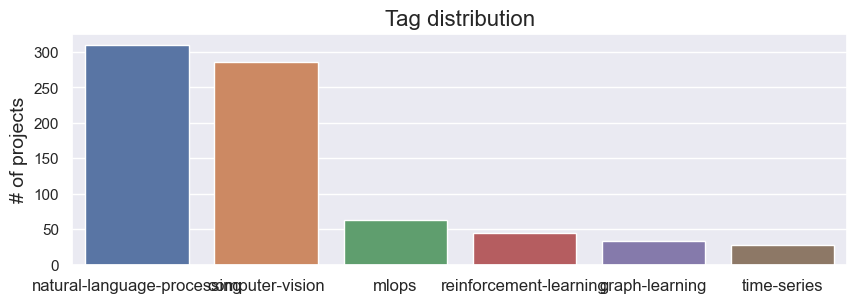

In [20]:
# Plot tag frequencies
tags, tag_counts = zip(*all_tags.most_common())
plt.figure(figsize=(10, 3))
ax = sns.barplot(x=list(tags), y=list(tag_counts))
ax.set_xticklabels(tags, rotation=0, fontsize=12)
plt.title("Tag distribution", fontsize=16)
plt.ylabel("# of projects", fontsize=14)
plt.show()

> We'll address the [data imbalance](https://madewithml.com/courses/mlops/baselines#data-imbalance) after splitting into our train split and prior to training our model.

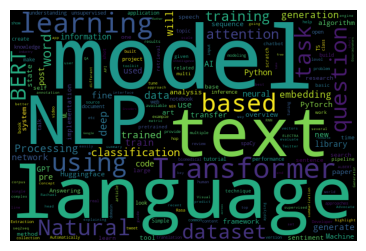

In [24]:
# Most frequent tokens for each tag
tag="natural-language-processing"
plt.figure(figsize=(10, 3))
subset = df[df.tag==tag]
text = subset.description.values
cloud = WordCloud(
    stopwords=STOPWORDS, background_color="black", collocations=False,
    width=600, height=400).generate(" ".join(text))
plt.axis("off")
plt.imshow(cloud)

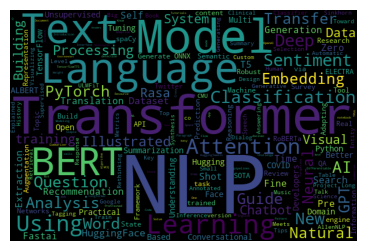

In [25]:
# Most frequent tokens for each tag
tag="natural-language-processing"
plt.figure(figsize=(10, 3))
subset = df[df.tag==tag]
text = subset.title.values
cloud = WordCloud(
    stopwords=STOPWORDS, background_color="black", collocations=False,
    width=600, height=400).generate(" ".join(text))
plt.axis("off")
plt.imshow(cloud)

Looks like the `title` text feature has some good signal for the respective classes and matches our intuition. We can repeat this for the `description` text feature as well. This information will become useful when we decide how to use our features for modeling.

## ✨&nbsp; Data Preprocessing

Preprocessing the data via feature engineering, filtering and cleaning. Certain preprocessing steps are global (don't depend on our dataset, ex. lower casing text, removing stop words, etc.) and others are local (constructs are learned only from the training split, ex. vocabulary, standardization, etc.). For the local, dataset-dependent preprocessing steps, we want to ensure that we [split](https://madewithml.com/courses/mlops/splitting) the data first before preprocessing to avoid data leaks.

In [16]:
import json
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
import re

### Feature engineering

We can combine existing input features to create new meaningful signal (helping the model learn). 

In [17]:
# Feature engineering
df["text"] = df.title + " " + df.description

### Clean text

In [18]:
nltk.download("stopwords")
STOPWORDS = stopwords.words("english")

[nltk_data] Downloading package stopwords to /home/ray/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [19]:
def clean_text(text, stopwords=STOPWORDS):
    """Clean raw text string."""
    # Lower
    text = text.lower()

    # Remove stopwords
    pattern = re.compile(r'\b(' + r"|".join(stopwords) + r")\b\s*")
    text = pattern.sub('', text)

    # Spacing and filters
    text = re.sub(r"([!\"'#$%&()*\+,-./:;<=>?@\\\[\]^_`{|}~])", r" \1 ", text)  # add spacing
    text = re.sub("[^A-Za-z0-9]+", " ", text)  # remove non alphanumeric chars
    text = re.sub(" +", " ", text)  # remove multiple spaces
    text = text.strip()  # strip white space at the ends
    text = re.sub(r"http\S+", "", text)  #  remove links
    
    return text

In [20]:
# Apply to dataframe
original_df = df.copy()
df.text = df.text.apply(clean_text)
print (f"{original_df.text.values[0]}\n{df.text.values[0]}")

Comparison between YOLO and RCNN on real world videos Bringing theory to experiment is cool. We can easily train models in colab and find the results in minutes.
comparison yolo rcnn real world videos bringing theory experiment cool easily train models colab find results minutes


### Clean DataFrame

In [21]:
# DataFrame cleanup
df = df.drop(columns=["id", "created_on", "title", "description"], errors="ignore")  # drop cols
df = df.dropna(subset=["tag"])  # drop nulls
df = df[["text", "tag"]]  # rearrange cols
df.head()

,text,tag
0,comparison yolo rcnn real world videos bringin...,computer-vision
1,show infer tell contextual inference creative ...,computer-vision
2,awesome graph classification collection import...,other
3,awesome monte carlo tree search curated list m...,other
4,attentionwalk pytorch implementation watch ste...,other


### Label encoding

We need to encode our data into numerical values so that our models can process them. We'll start by encoding our text labels into unique indices.

In [22]:
# Label to index
tags = train_df.tag.unique().tolist()
num_classes = len(tags)
class_to_index = {tag: i for i, tag in enumerate(tags)}
class_to_index

{'mlops': 0,
 'natural-language-processing': 1,
 'computer-vision': 2,
 'other': 3}

In [23]:
# Encode labels
df["tag"] = df["tag"].map(class_to_index)
df.head()

,text,tag
0,comparison yolo rcnn real world videos bringin...,2
1,show infer tell contextual inference creative ...,2
2,awesome graph classification collection import...,3
3,awesome monte carlo tree search curated list m...,3
4,attentionwalk pytorch implementation watch ste...,3


In [24]:
def decode(indices, index_to_class):
    return [index_to_class[index] for index in indices]

In [25]:
index_to_class = {v:k for k, v in class_to_index.items()}
decode(df.head()["tag"].values, index_to_class=index_to_class)

['computer-vision', 'computer-vision', 'other', 'other', 'other']

### Tokenizer

Next we'll encode our text as well. Instead of using a random dictionary, we'll use a [tokenizer](https://huggingface.co/allenai/scibert_scivocab_uncased/blob/main/vocab.txt) that was used for a pretrained LLM ([scibert](https://huggingface.co/allenai/scibert_scivocab_uncased)) to tokenize our text. We'll be fine-tuning this exact model later when we train our model.

In [26]:
import numpy as np
from transformers import BertTokenizer

In [27]:
# Bert tokenizer
tokenizer = BertTokenizer.from_pretrained("allenai/scibert_scivocab_uncased", return_dict=False)
text = "Transfer learning with transformers for text classification."
encoded_inputs = tokenizer([text], return_tensors="np", padding="longest")  # pad to longest item in batch
print ("input_ids:", encoded_inputs["input_ids"])
print ("attention_mask:", encoded_inputs["attention_mask"])
print (tokenizer.decode(encoded_inputs["input_ids"][0]))

input_ids: [[  102  2268  1904   190 29155   168  3267  2998   205   103]]
attention_mask: [[1 1 1 1 1 1 1 1 1 1]]
[CLS] transfer learning with transformers for text classification. [SEP]


In [28]:
def tokenize(batch):
    tokenizer = BertTokenizer.from_pretrained("allenai/scibert_scivocab_uncased", return_dict=False)
    encoded_inputs = tokenizer(batch["text"].tolist(), return_tensors="np", padding="longest")
    return dict(ids=encoded_inputs["input_ids"], masks=encoded_inputs["attention_mask"], targets=np.array(batch["tag"]))

In [29]:
# Tokenization
tokenize(df.head(1))

{'ids': array([[  102,  2029,  1778,   609,  6446,  4857,  1332,  2399, 13572,
         19125,  1983,  1954,  6240,  3717,  7434,  1262,   537,   201,
          1040,   545,  4714,   103]]),
 'masks': array([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]]),
 'targets': array([2])}

<hr>

We'll combine all of our preprocessing steps into function:

In [30]:
def preprocess(df, class_to_index):
    """Preprocess the data."""
    df["text"] = df.title + " " + df.description  # feature engineering
    df["text"] = df.text.apply(clean_text)  # clean text
    df = df.drop(columns=["id", "created_on", "title", "description"], errors="ignore")  # clean dataframe
    df = df[["text", "tag"]]  # rearrange columns
    df["tag"] = df["tag"].map(class_to_index)  # label encoding
    outputs = tokenize(df)
    return outputs

In [31]:
# Apply
preprocess(df=train_df, class_to_index=class_to_index)

{'ids': array([[  102,   856,   532, ...,     0,     0,     0],
        [  102,  2177, 29155, ...,     0,     0,     0],
        [  102,  2180,  3241, ...,     0,     0,     0],
        ...,
        [  102,   453,  2068, ...,  5730,   432,   103],
        [  102, 11268,  1782, ...,     0,     0,     0],
        [  102,  1596,   122, ...,     0,     0,     0]]),
 'masks': array([[1, 1, 1, ..., 0, 0, 0],
        [1, 1, 1, ..., 0, 0, 0],
        [1, 1, 1, ..., 0, 0, 0],
        ...,
        [1, 1, 1, ..., 1, 1, 1],
        [1, 1, 1, ..., 0, 0, 0],
        [1, 1, 1, ..., 0, 0, 0]]),
 'targets': array([0, 1, 1, 1, 1, 2, 1, 2, 3, 1, 2, 2, 1, 1, 2, 2, 2, 2, 1, 2, 0, 1,
        1, 1, 1, 1, 2, 1, 2, 0, 3, 2, 0, 1, 1, 1, 1, 2, 1, 1, 0, 2, 3, 3,
        3, 0, 2, 1, 3, 3, 1, 1, 1, 1, 2, 1, 2, 2, 2, 3, 2, 1, 1, 3, 1, 0,
        1, 2, 2, 2, 3, 2, 3, 2, 3, 2, 1, 1, 3, 3, 3, 1, 1, 2, 3, 0, 1, 1,
        1, 1, 3, 3, 0, 2, 3, 2, 2, 1, 1, 3, 2, 3, 1, 1, 1, 1, 2, 0, 0, 2,
        1, 1, 2, 2, 1, 1, 0, 3, 1

### Distributed preprocessing

The main issue with our approach above is that we're limited by our single machine in terms how much data our dataframe can hold and that we can preprocess. With the increasing trend in ML for larger unstructured datasets and larger models (LLMs), we can quickly outgrow our single machine constraints and will need to go distributed.

In [32]:
import sys
sys.path.append("..")
from madewithml.data import stratify_split
ray.data.DatasetContext.get_current().execution_options.preserve_order = True

In [33]:
# Data ingestion
ds = ray.data.read_csv(DATASET_LOC)
ds = ds.random_shuffle(seed=1234)
ds.take(1)

2023-07-24 18:09:40,715	INFO read_api.py:374 -- To satisfy the requested parallelism of 16, each read task output will be split into 16 smaller blocks.
2023-07-24 18:09:40,719	INFO dataset.py:2180 -- Tip: Use `take_batch()` instead of `take() / show()` to return records in pandas or numpy batch format.
2023-07-24 18:09:40,720	INFO streaming_executor.py:92 -- Executing DAG InputDataBuffer[Input] -> TaskPoolMapOperator[ReadCSV->SplitBlocks(16)] -> AllToAllOperator[RandomShuffle]
2023-07-24 18:09:40,721	INFO streaming_executor.py:93 -- Execution config: ExecutionOptions(resource_limits=ExecutionResources(cpu=None, gpu=None, object_store_memory=None), locality_with_output=False, preserve_order=True, actor_locality_enabled=True, verbose_progress=False)
2023-07-24 18:09:40,722	INFO streaming_executor.py:95 -- Tip: For detailed progress reporting, run `ray.data.DataContext.get_current().execution_options.verbose_progress = True`


- RandomShuffle 1:   0%|          | 0/16 [00:00<?, ?it/s]

Shuffle Map 2:   0%|          | 0/16 [00:00<?, ?it/s]

Shuffle Reduce 3:   0%|          | 0/16 [00:00<?, ?it/s]

Running 0:   0%|          | 0/16 [00:00<?, ?it/s]

[{'id': 428,
  'created_on': datetime.datetime(2020, 4, 10, 4, 57, 53),
  'title': 'AiLight: Automatic  Highlighting Using BERT',
  'description': 'Automatically highlight pdfs using BERT embeddings and clustering. \r\nhttps://anishthite.github.io/ailight',
  'tag': 'natural-language-processing'}]

In [34]:
# Split dataset
test_size = 0.2
train_ds, val_ds = stratify_split(ds, stratify="tag", test_size=test_size)

2023-07-24 18:09:41,436	INFO streaming_executor.py:92 -- Executing DAG InputDataBuffer[Input] -> TaskPoolMapOperator[ReadCSV->SplitBlocks(16)] -> AllToAllOperator[RandomShuffle] -> LimitOperator[limit=1]
2023-07-24 18:09:41,438	INFO streaming_executor.py:93 -- Execution config: ExecutionOptions(resource_limits=ExecutionResources(cpu=None, gpu=None, object_store_memory=None), locality_with_output=False, preserve_order=True, actor_locality_enabled=True, verbose_progress=False)
2023-07-24 18:09:41,439	INFO streaming_executor.py:95 -- Tip: For detailed progress reporting, run `ray.data.DataContext.get_current().execution_options.verbose_progress = True`


- RandomShuffle 1:   0%|          | 0/16 [00:00<?, ?it/s]

Shuffle Map 2:   0%|          | 0/16 [00:00<?, ?it/s]

Shuffle Reduce 3:   0%|          | 0/16 [00:00<?, ?it/s]

Running 0:   0%|          | 0/1 [00:00<?, ?it/s]

In [35]:
# Mapping
tags = train_ds.unique(column="tag")
class_to_index = {tag: i for i, tag in enumerate(tags)}

2023-07-24 18:09:45,958	INFO streaming_executor.py:92 -- Executing DAG InputDataBuffer[Input] -> TaskPoolMapOperator[ReadCSV->SplitBlocks(16)] -> AllToAllOperator[RandomShuffle] -> AllToAllOperator[Sort] -> AllToAllOperator[MapBatches(group_fn)->MapBatches(_filter_split)->RandomShuffle] -> LimitOperator[limit=1]
2023-07-24 18:09:45,960	INFO streaming_executor.py:93 -- Execution config: ExecutionOptions(resource_limits=ExecutionResources(cpu=None, gpu=None, object_store_memory=None), locality_with_output=False, preserve_order=True, actor_locality_enabled=True, verbose_progress=False)
2023-07-24 18:09:45,961	INFO streaming_executor.py:95 -- Tip: For detailed progress reporting, run `ray.data.DataContext.get_current().execution_options.verbose_progress = True`


- RandomShuffle 1:   0%|          | 0/16 [00:00<?, ?it/s]

Shuffle Map 2:   0%|          | 0/16 [00:00<?, ?it/s]

Shuffle Reduce 3:   0%|          | 0/16 [00:00<?, ?it/s]

- Sort 4:   0%|          | 0/16 [00:00<?, ?it/s]

Sort Sample 5:   0%|          | 0/16 [00:00<?, ?it/s]

Shuffle Map 6:   0%|          | 0/16 [00:00<?, ?it/s]

Shuffle Reduce 7:   0%|          | 0/16 [00:00<?, ?it/s]

- MapBatches(group_fn)->MapBatches(_filter_split)->RandomShuffle 8:   0%|          | 0/16 [00:00<?, ?it/s]

Shuffle Map 9:   0%|          | 0/16 [00:00<?, ?it/s]

Shuffle Reduce 10:   0%|          | 0/16 [00:00<?, ?it/s]

Running 0:   0%|          | 0/1 [00:00<?, ?it/s]

Sort Sample 0:   0%|          | 0/16 [00:00<?, ?it/s]

2023-07-24 18:09:47,953	INFO streaming_executor.py:92 -- Executing DAG InputDataBuffer[Input] -> TaskPoolMapOperator[ReadCSV->SplitBlocks(16)] -> AllToAllOperator[RandomShuffle] -> AllToAllOperator[Sort] -> AllToAllOperator[MapBatches(group_fn)->MapBatches(_filter_split)->RandomShuffle] -> AllToAllOperator[Aggregate] -> TaskPoolMapOperator[MapBatches(<lambda>)]
2023-07-24 18:09:47,955	INFO streaming_executor.py:93 -- Execution config: ExecutionOptions(resource_limits=ExecutionResources(cpu=None, gpu=None, object_store_memory=None), locality_with_output=False, preserve_order=True, actor_locality_enabled=True, verbose_progress=False)
2023-07-24 18:09:47,957	INFO streaming_executor.py:95 -- Tip: For detailed progress reporting, run `ray.data.DataContext.get_current().execution_options.verbose_progress = True`


- RandomShuffle 1:   0%|          | 0/16 [00:00<?, ?it/s]

Shuffle Map 2:   0%|          | 0/16 [00:00<?, ?it/s]

Shuffle Reduce 3:   0%|          | 0/16 [00:00<?, ?it/s]

- Sort 4:   0%|          | 0/16 [00:00<?, ?it/s]

Sort Sample 5:   0%|          | 0/16 [00:00<?, ?it/s]

Shuffle Map 6:   0%|          | 0/16 [00:00<?, ?it/s]

Shuffle Reduce 7:   0%|          | 0/16 [00:00<?, ?it/s]

- MapBatches(group_fn)->MapBatches(_filter_split)->RandomShuffle 8:   0%|          | 0/16 [00:00<?, ?it/s]

Shuffle Map 9:   0%|          | 0/16 [00:00<?, ?it/s]

Shuffle Reduce 10:   0%|          | 0/16 [00:00<?, ?it/s]

- Aggregate 11:   0%|          | 0/16 [00:00<?, ?it/s]

Shuffle Map 12:   0%|          | 0/16 [00:00<?, ?it/s]

Shuffle Reduce 13:   0%|          | 0/16 [00:00<?, ?it/s]

Running 0:   0%|          | 0/16 [00:00<?, ?it/s]

Sort Sample 0:   0%|          | 0/16 [00:00<?, ?it/s]

Sort Sample 0:   0%|          | 0/16 [00:00<?, ?it/s]

In [36]:
# Distributed preprocessing
sample_ds = train_ds.map_batches(preprocess, fn_kwargs={"class_to_index": class_to_index}, batch_format="pandas")
sample_ds.show(1)

2023-07-24 18:09:48,800	INFO streaming_executor.py:92 -- Executing DAG InputDataBuffer[Input] -> TaskPoolMapOperator[ReadCSV->SplitBlocks(16)] -> AllToAllOperator[RandomShuffle] -> AllToAllOperator[Sort] -> AllToAllOperator[MapBatches(group_fn)->MapBatches(_filter_split)->RandomShuffle] -> TaskPoolMapOperator[MapBatches(preprocess)]
2023-07-24 18:09:48,802	INFO streaming_executor.py:93 -- Execution config: ExecutionOptions(resource_limits=ExecutionResources(cpu=None, gpu=None, object_store_memory=None), locality_with_output=False, preserve_order=True, actor_locality_enabled=True, verbose_progress=False)
2023-07-24 18:09:48,802	INFO streaming_executor.py:95 -- Tip: For detailed progress reporting, run `ray.data.DataContext.get_current().execution_options.verbose_progress = True`


- RandomShuffle 1:   0%|          | 0/16 [00:00<?, ?it/s]

Shuffle Map 2:   0%|          | 0/16 [00:00<?, ?it/s]

Shuffle Reduce 3:   0%|          | 0/16 [00:00<?, ?it/s]

- Sort 4:   0%|          | 0/16 [00:00<?, ?it/s]

Sort Sample 5:   0%|          | 0/16 [00:00<?, ?it/s]

Shuffle Map 6:   0%|          | 0/16 [00:00<?, ?it/s]

Shuffle Reduce 7:   0%|          | 0/16 [00:00<?, ?it/s]

- MapBatches(group_fn)->MapBatches(_filter_split)->RandomShuffle 8:   0%|          | 0/16 [00:00<?, ?it/s]

Shuffle Map 9:   0%|          | 0/16 [00:00<?, ?it/s]

Shuffle Reduce 10:   0%|          | 0/16 [00:00<?, ?it/s]

Running 0:   0%|          | 0/16 [00:00<?, ?it/s]

Sort Sample 0:   0%|          | 0/16 [00:00<?, ?it/s]

{'ids': array([ 102, 2189, 2782, 6487, 4220,  545, 3997, 1904, 5995,  103,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0]), 'masks': array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]), 'targets': 0}


# Training

When developing models, it's always a best practice to start with the simplest models and slowly motivate more complex models. For example our baseline model progression would be: 

1. random model (predict labels randomly)
2. rule-based model (pattern match labels in input text)
3. logistic regression (td-idf vectors from text)
4. CNN (apply character filters over text)
5. Fine-tune LLM (this notebook)

We cover all of these methods in our [other lessons](https://madewithml.com/#foundations) but since our focus here in on MLOps, we will skip directly to fine-tuning an LLM for our task.

We'll first set up some functions that will help us achieve complete reproducibility.

In [37]:
import os
import random
import torch
from ray.data.preprocessor import Preprocessor

In [38]:
def set_seeds(seed=42):
    """Set seeds for reproducibility."""
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    eval("setattr(torch.backends.cudnn, 'deterministic', True)")
    eval("setattr(torch.backends.cudnn, 'benchmark', False)")
    os.environ["PYTHONHASHSEED"] = str(seed)

In [39]:
def load_data(num_samples=None):
    ds = ray.data.read_csv(DATASET_LOC)
    ds = ds.random_shuffle(seed=1234)
    ds = ray.data.from_items(ds.take(num_samples)) if num_samples else ds
    return ds

In [40]:
class CustomPreprocessor(Preprocessor):
    """Custom preprocessor class."""
    def _fit(self, ds):
        tags = ds.unique(column="tag")
        self.class_to_index = {tag: i for i, tag in enumerate(tags)}
        self.index_to_class = {v:k for k, v in self.class_to_index.items()}
    def _transform_pandas(self, batch):  # could also do _transform_numpy
        return preprocess(batch, class_to_index=self.class_to_index)

## 🤖&nbsp; Model

In [41]:
import torch.nn as nn
from transformers import BertModel

In [42]:
# Pretrained LLM
llm = BertModel.from_pretrained("allenai/scibert_scivocab_uncased", return_dict=False)
embedding_dim = llm.config.hidden_size

Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertModel: ['cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.decoder.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [43]:
# Sample
text = "Transfer learning with transformers for text classification."
batch = tokenizer([text], return_tensors="np", padding="longest")
batch = {k:torch.tensor(v) for k,v in batch.items()}  # convert to torch tensors
seq, pool = llm(input_ids=batch["input_ids"], attention_mask=batch["attention_mask"])
np.shape(seq), np.shape(pool)

(torch.Size([1, 10, 768]), torch.Size([1, 768]))

In [44]:
class FinetunedLLM(nn.Module):
    def __init__(self, llm, dropout_p, embedding_dim, num_classes):
        super(FinetunedLLM, self).__init__()
        self.llm = llm
        self.dropout = torch.nn.Dropout(dropout_p)
        self.fc1 = torch.nn.Linear(embedding_dim, num_classes)

    def forward(self, batch):
        ids, masks = batch["ids"], batch["masks"]
        seq, pool = self.llm(input_ids=ids, attention_mask=masks)
        z = self.dropout(pool)
        z = self.fc1(z)
        return z
    
    @torch.inference_mode()
    def predict(self, batch):
        self.eval()
        z = self(inputs)
        y_pred = torch.argmax(z, dim=1).cpu().numpy()
        return y_pred
    
    @torch.inference_mode()
    def predict_proba(self, batch):
        self.eval()
        z = self(batch)
        y_probs = F.softmax(z).cpu().numpy()
        return y_probs

In [45]:
# Initialize model
model = FinetunedLLM(llm=llm, dropout_p=0.5, embedding_dim=embedding_dim, num_classes=num_classes)
print (model.named_parameters)

<bound method Module.named_parameters of FinetunedLLM(
  (llm): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(31090, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): Layer

## 📦&nbsp; Batching

We can iterate through our dataset in batches however we may have batches of different sizes. Recall that our tokenizer padded the inputs to the longest item in the batch (`padding="longest"`). However, our batches for training will be smaller than our large data processing batches and so our batches here may have inputs with different lengths. To address this, we're going to define a custom `collate_fn` to repad the items in our training batches.

In [46]:
from ray.train.torch import get_device

Created a temporary directory at /tmp/tmpmgh7ddc7
Writing /tmp/tmpmgh7ddc7/_remote_module_non_scriptable.py


In [47]:
def pad_array(arr, dtype=np.int32):
    max_len = max(len(row) for row in arr)
    padded_arr = np.zeros((arr.shape[0], max_len), dtype=dtype)
    for i, row in enumerate(arr):
        padded_arr[i][:len(row)] = row
    return padded_arr

In [48]:
def collate_fn(batch):
    batch["ids"] = pad_array(batch["ids"])
    batch["masks"] = pad_array(batch["masks"])
    dtypes = {"ids": torch.int32, "masks": torch.int32, "targets": torch.int64}
    tensor_batch = {}
    for key, array in batch.items():
        tensor_batch[key] = torch.as_tensor(array, dtype=dtypes[key], device=get_device())
    return tensor_batch

> `pad=(0, max_len)` in [F.pad](https://pytorch.org/docs/stable/generated/torch.nn.functional.pad.html#torch-nn-functional-pad) refers to (left_padding, right_padding) on the input. There will be no left-padding (hence the `0`) and only right-padding. And the `constant` mode refers to each element being padded to a constant size (size of longest element in the input).

In [49]:
# Sample batch
sample_batch = sample_ds.take_batch(batch_size=128)
collate_fn(batch=sample_batch)

2023-07-24 18:09:52,025	INFO streaming_executor.py:92 -- Executing DAG InputDataBuffer[Input] -> TaskPoolMapOperator[ReadCSV->SplitBlocks(16)] -> AllToAllOperator[RandomShuffle] -> AllToAllOperator[Sort] -> AllToAllOperator[MapBatches(group_fn)->MapBatches(_filter_split)->RandomShuffle] -> TaskPoolMapOperator[MapBatches(preprocess)]
2023-07-24 18:09:52,026	INFO streaming_executor.py:93 -- Execution config: ExecutionOptions(resource_limits=ExecutionResources(cpu=None, gpu=None, object_store_memory=None), locality_with_output=False, preserve_order=True, actor_locality_enabled=True, verbose_progress=False)
2023-07-24 18:09:52,026	INFO streaming_executor.py:95 -- Tip: For detailed progress reporting, run `ray.data.DataContext.get_current().execution_options.verbose_progress = True`


- RandomShuffle 1:   0%|          | 0/16 [00:00<?, ?it/s]

Shuffle Map 2:   0%|          | 0/16 [00:00<?, ?it/s]

Shuffle Reduce 3:   0%|          | 0/16 [00:00<?, ?it/s]

- Sort 4:   0%|          | 0/16 [00:00<?, ?it/s]

Sort Sample 5:   0%|          | 0/16 [00:00<?, ?it/s]

Shuffle Map 6:   0%|          | 0/16 [00:00<?, ?it/s]

Shuffle Reduce 7:   0%|          | 0/16 [00:00<?, ?it/s]

- MapBatches(group_fn)->MapBatches(_filter_split)->RandomShuffle 8:   0%|          | 0/16 [00:00<?, ?it/s]

Shuffle Map 9:   0%|          | 0/16 [00:00<?, ?it/s]

Shuffle Reduce 10:   0%|          | 0/16 [00:00<?, ?it/s]

Running 0:   0%|          | 0/16 [00:00<?, ?it/s]

Sort Sample 0:   0%|          | 0/16 [00:00<?, ?it/s]

{'ids': tensor([[  102,  2189,  2782,  ...,     0,     0,     0],
         [  102,  3997,  1904,  ...,     0,     0,     0],
         [  102,  3155, 13558,  ...,     0,     0,     0],
         ...,
         [  102,  1477,  1995,  ...,     0,     0,     0],
         [  102,  7683,  5011,  ...,     0,     0,     0],
         [  102,  1968,   510,  ...,     0,     0,     0]], dtype=torch.int32),
 'masks': tensor([[1, 1, 1,  ..., 0, 0, 0],
         [1, 1, 1,  ..., 0, 0, 0],
         [1, 1, 1,  ..., 0, 0, 0],
         ...,
         [1, 1, 1,  ..., 0, 0, 0],
         [1, 1, 1,  ..., 0, 0, 0],
         [1, 1, 1,  ..., 0, 0, 0]], dtype=torch.int32),
 'targets': tensor([0, 1, 2, 0, 0, 2, 3, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 2, 2, 3, 1, 3, 0, 2,
         0, 1, 3, 2, 2, 2, 2, 3, 2, 2, 2, 2, 1, 2, 0, 3, 2, 0, 1, 2, 0, 0, 2, 3,
         0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 2, 2, 3, 1, 3, 0, 2, 0, 1, 3, 2, 2, 2, 2,
         3, 2, 2, 2, 2, 1, 2, 0, 3, 2, 0, 3, 0, 0, 0, 2, 2, 2, 0, 2, 0, 0, 0, 0,
         0, 0, 

## 🧮&nbsp; Utilities

In [50]:
from ray.air import Checkpoint, session
from ray.air.config import CheckpointConfig, DatasetConfig, RunConfig, ScalingConfig
import ray.train as train
from ray.train.torch import TorchCheckpoint, TorchTrainer
import torch.nn.functional as F

In [51]:
def train_step(ds, batch_size, model, num_classes, loss_fn, optimizer):
    """Train step."""
    model.train()
    loss = 0.0
    ds_generator = ds.iter_torch_batches(batch_size=batch_size, collate_fn=collate_fn)
    for i, batch in enumerate(ds_generator):
        optimizer.zero_grad()  # reset gradients
        z = model(batch)  # forward pass
        targets = F.one_hot(batch["targets"], num_classes=num_classes).float()  # one-hot (for loss_fn)
        J = loss_fn(z, targets)  # define loss
        J.backward()  # backward pass
        optimizer.step()  # update weights
        loss += (J.detach().item() - loss) / (i + 1)  # cumulative loss
    return loss

In [52]:
def eval_step(ds, batch_size, model, num_classes, loss_fn):
    """Eval step."""
    model.eval()
    loss = 0.0
    y_trues, y_preds = [], []
    ds_generator = ds.iter_torch_batches(batch_size=batch_size, collate_fn=collate_fn)
    with torch.inference_mode():
        for i, batch in enumerate(ds_generator):
            z = model(batch)
            targets = F.one_hot(batch["targets"], num_classes=num_classes).float()  # one-hot (for loss_fn)
            J = loss_fn(z, targets).item()
            loss += (J - loss) / (i + 1)
            y_trues.extend(batch["targets"].cpu().numpy())
            y_preds.extend(torch.argmax(z, dim=1).cpu().numpy())
    return loss, np.vstack(y_trues), np.vstack(y_preds)

In [53]:
# Training loop
def train_loop_per_worker(config):
    # Hyperparameters
    dropout_p = config["dropout_p"]
    lr = config["lr"]
    lr_factor = config["lr_factor"]
    lr_patience = config["lr_patience"]
    num_epochs = config["num_epochs"]
    batch_size = config["batch_size"]
    num_classes = config["num_classes"]

    # Get datasets
    set_seeds()
    train_ds = session.get_dataset_shard("train")
    val_ds = session.get_dataset_shard("val")

    # Model
    llm = BertModel.from_pretrained("allenai/scibert_scivocab_uncased", return_dict=False)
    model = FinetunedLLM(llm=llm, dropout_p=dropout_p, embedding_dim=llm.config.hidden_size, num_classes=num_classes)
    model = train.torch.prepare_model(model)

    # Training components
    loss_fn = nn.BCEWithLogitsLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode="min", factor=lr_factor, patience=lr_patience)

    # Training
    batch_size_per_worker = batch_size // session.get_world_size()
    for epoch in range(num_epochs):
        # Step
        train_loss = train_step(train_ds, batch_size_per_worker, model, num_classes, loss_fn, optimizer)
        val_loss, _, _ = eval_step(val_ds, batch_size_per_worker, model, num_classes, loss_fn)
        scheduler.step(val_loss)

        # Checkpoint
        metrics = dict(epoch=epoch, lr=optimizer.param_groups[0]["lr"], train_loss=train_loss, val_loss=val_loss)
        checkpoint = TorchCheckpoint.from_model(model=model)
        session.report(metrics, checkpoint=checkpoint)

Our dataset doesn't suffer from horrible class imbalance, but if it did, we could easily account for it through our loss function. There are also other strategies such as [over-sampling](https://imbalanced-learn.org/stable/over_sampling.html) less frequent classes and [under-sampling](https://imbalanced-learn.org/stable/under_sampling.html) popular classes.

```python
# Class weights
batch_counts = []
for batch in train_ds.iter_torch_batches(batch_size=256, collate_fn=collate_fn):
    batch_counts.append(np.bincount(batch["targets"].cpu().numpy()))
counts = [sum(count) for count in zip(*batch_counts)]
class_weights = np.array([1.0/count for i, count in enumerate(counts)])
class_weights_tensor = torch.Tensor(class_weights).to(get_device())

# Training components
loss_fn = nn.BCEWithLogitsLoss(weight=class_weights_tensor)
...
```

## 🗂️&nbsp; Configurations

In [54]:
# Train loop config
train_loop_config = {
    "dropout_p": 0.5,
    "lr": 1e-4,
    "lr_factor": 0.8,
    "lr_patience": 3,
    "num_epochs": 10,
    "batch_size": 256,
    "num_classes": num_classes,
}

In [55]:
# Scaling config
scaling_config = ScalingConfig(
    num_workers=num_workers,
    use_gpu=bool(resources_per_worker["GPU"]),
    resources_per_worker=resources_per_worker,
    _max_cpu_fraction_per_node=0.8,
)

In [56]:
# Run config
checkpoint_config = CheckpointConfig(num_to_keep=1, checkpoint_score_attribute="val_loss", checkpoint_score_order="min")
run_config = RunConfig(name="llm", checkpoint_config=checkpoint_config, local_dir="~/ray_results")

## 🚂&nbsp; Training

In [57]:
# Dataset
ds = load_data()
train_ds, val_ds = stratify_split(ds, stratify="tag", test_size=test_size)

2023-07-24 18:09:53,138	INFO read_api.py:374 -- To satisfy the requested parallelism of 16, each read task output will be split into 16 smaller blocks.
2023-07-24 18:09:53,142	INFO streaming_executor.py:92 -- Executing DAG InputDataBuffer[Input] -> TaskPoolMapOperator[ReadCSV->SplitBlocks(16)] -> AllToAllOperator[RandomShuffle] -> LimitOperator[limit=1]
2023-07-24 18:09:53,142	INFO streaming_executor.py:93 -- Execution config: ExecutionOptions(resource_limits=ExecutionResources(cpu=None, gpu=None, object_store_memory=None), locality_with_output=False, preserve_order=True, actor_locality_enabled=True, verbose_progress=False)
2023-07-24 18:09:53,143	INFO streaming_executor.py:95 -- Tip: For detailed progress reporting, run `ray.data.DataContext.get_current().execution_options.verbose_progress = True`


- RandomShuffle 1:   0%|          | 0/16 [00:00<?, ?it/s]

Shuffle Map 2:   0%|          | 0/16 [00:00<?, ?it/s]

Shuffle Reduce 3:   0%|          | 0/16 [00:00<?, ?it/s]

Running 0:   0%|          | 0/1 [00:00<?, ?it/s]

In [58]:
# Preprocess
preprocessor = CustomPreprocessor()
train_ds =  preprocessor.fit_transform(train_ds)
val_ds = preprocessor.transform(val_ds)
train_ds = train_ds.materialize()
val_ds = val_ds.materialize()

2023-07-24 18:09:53,359	WARNING plan.py:567 -- Warning: The Ray cluster currently does not have any available CPUs. The Dataset job will hang unless more CPUs are freed up. A common reason is that cluster resources are used by Actors or Tune trials; see the following link for more details: https://docs.ray.io/en/master/data/dataset-internals.html#datasets-and-tune
2023-07-24 18:09:53,360	INFO streaming_executor.py:92 -- Executing DAG InputDataBuffer[Input] -> TaskPoolMapOperator[ReadCSV->SplitBlocks(16)] -> AllToAllOperator[RandomShuffle] -> AllToAllOperator[Sort] -> AllToAllOperator[MapBatches(group_fn)->MapBatches(_filter_split)->RandomShuffle] -> LimitOperator[limit=1]
2023-07-24 18:09:53,361	INFO streaming_executor.py:93 -- Execution config: ExecutionOptions(resource_limits=ExecutionResources(cpu=None, gpu=None, object_store_memory=None), locality_with_output=False, preserve_order=True, actor_locality_enabled=True, verbose_progress=False)
2023-07-24 18:09:53,362	INFO streaming_exec

- RandomShuffle 1:   0%|          | 0/16 [00:00<?, ?it/s]

Shuffle Map 2:   0%|          | 0/16 [00:00<?, ?it/s]

Shuffle Reduce 3:   0%|          | 0/16 [00:00<?, ?it/s]

- Sort 4:   0%|          | 0/16 [00:00<?, ?it/s]

Sort Sample 5:   0%|          | 0/16 [00:00<?, ?it/s]

Shuffle Map 6:   0%|          | 0/16 [00:00<?, ?it/s]

Shuffle Reduce 7:   0%|          | 0/16 [00:00<?, ?it/s]

- MapBatches(group_fn)->MapBatches(_filter_split)->RandomShuffle 8:   0%|          | 0/16 [00:00<?, ?it/s]

Shuffle Map 9:   0%|          | 0/16 [00:00<?, ?it/s]

Shuffle Reduce 10:   0%|          | 0/16 [00:00<?, ?it/s]

Running 0:   0%|          | 0/1 [00:00<?, ?it/s]

Sort Sample 0:   0%|          | 0/16 [00:00<?, ?it/s]

2023-07-24 18:09:53,952	INFO streaming_executor.py:92 -- Executing DAG InputDataBuffer[Input] -> TaskPoolMapOperator[ReadCSV->SplitBlocks(16)] -> AllToAllOperator[RandomShuffle] -> AllToAllOperator[Sort] -> AllToAllOperator[MapBatches(group_fn)->MapBatches(_filter_split)->RandomShuffle] -> AllToAllOperator[Aggregate] -> TaskPoolMapOperator[MapBatches(<lambda>)]
2023-07-24 18:09:53,953	INFO streaming_executor.py:93 -- Execution config: ExecutionOptions(resource_limits=ExecutionResources(cpu=None, gpu=None, object_store_memory=None), locality_with_output=False, preserve_order=True, actor_locality_enabled=True, verbose_progress=False)
2023-07-24 18:09:53,953	INFO streaming_executor.py:95 -- Tip: For detailed progress reporting, run `ray.data.DataContext.get_current().execution_options.verbose_progress = True`


- RandomShuffle 1:   0%|          | 0/16 [00:00<?, ?it/s]

Shuffle Map 2:   0%|          | 0/16 [00:00<?, ?it/s]

Shuffle Reduce 3:   0%|          | 0/16 [00:00<?, ?it/s]

- Sort 4:   0%|          | 0/16 [00:00<?, ?it/s]

Sort Sample 5:   0%|          | 0/16 [00:00<?, ?it/s]

Shuffle Map 6:   0%|          | 0/16 [00:00<?, ?it/s]

Shuffle Reduce 7:   0%|          | 0/16 [00:00<?, ?it/s]

- MapBatches(group_fn)->MapBatches(_filter_split)->RandomShuffle 8:   0%|          | 0/16 [00:00<?, ?it/s]

Shuffle Map 9:   0%|          | 0/16 [00:00<?, ?it/s]

Shuffle Reduce 10:   0%|          | 0/16 [00:00<?, ?it/s]

- Aggregate 11:   0%|          | 0/16 [00:00<?, ?it/s]

Shuffle Map 12:   0%|          | 0/16 [00:00<?, ?it/s]

Shuffle Reduce 13:   0%|          | 0/16 [00:00<?, ?it/s]

Running 0:   0%|          | 0/16 [00:00<?, ?it/s]

Sort Sample 0:   0%|          | 0/16 [00:00<?, ?it/s]

Sort Sample 0:   0%|          | 0/16 [00:00<?, ?it/s]

2023-07-24 18:09:54,692	INFO streaming_executor.py:92 -- Executing DAG InputDataBuffer[Input] -> TaskPoolMapOperator[ReadCSV->SplitBlocks(16)] -> AllToAllOperator[RandomShuffle] -> AllToAllOperator[Sort] -> AllToAllOperator[MapBatches(group_fn)->MapBatches(_filter_split)->RandomShuffle] -> TaskPoolMapOperator[MapBatches(CustomPreprocessor._transform_pandas)]
2023-07-24 18:09:54,693	INFO streaming_executor.py:93 -- Execution config: ExecutionOptions(resource_limits=ExecutionResources(cpu=None, gpu=None, object_store_memory=None), locality_with_output=False, preserve_order=True, actor_locality_enabled=True, verbose_progress=False)
2023-07-24 18:09:54,693	INFO streaming_executor.py:95 -- Tip: For detailed progress reporting, run `ray.data.DataContext.get_current().execution_options.verbose_progress = True`


- RandomShuffle 1:   0%|          | 0/16 [00:00<?, ?it/s]

Shuffle Map 2:   0%|          | 0/16 [00:00<?, ?it/s]

Shuffle Reduce 3:   0%|          | 0/16 [00:00<?, ?it/s]

- Sort 4:   0%|          | 0/16 [00:00<?, ?it/s]

Sort Sample 5:   0%|          | 0/16 [00:00<?, ?it/s]

Shuffle Map 6:   0%|          | 0/16 [00:00<?, ?it/s]

Shuffle Reduce 7:   0%|          | 0/16 [00:00<?, ?it/s]

- MapBatches(group_fn)->MapBatches(_filter_split)->RandomShuffle 8:   0%|          | 0/16 [00:00<?, ?it/s]

Shuffle Map 9:   0%|          | 0/16 [00:00<?, ?it/s]

Shuffle Reduce 10:   0%|          | 0/16 [00:00<?, ?it/s]

Running 0:   0%|          | 0/16 [00:00<?, ?it/s]

Sort Sample 0:   0%|          | 0/16 [00:00<?, ?it/s]

2023-07-24 18:09:55,679	INFO streaming_executor.py:92 -- Executing DAG InputDataBuffer[Input] -> TaskPoolMapOperator[ReadCSV->SplitBlocks(16)] -> AllToAllOperator[RandomShuffle] -> AllToAllOperator[Sort] -> AllToAllOperator[MapBatches(group_fn)->MapBatches(_filter_split)->RandomShuffle] -> TaskPoolMapOperator[MapBatches(CustomPreprocessor._transform_pandas)]
2023-07-24 18:09:55,680	INFO streaming_executor.py:93 -- Execution config: ExecutionOptions(resource_limits=ExecutionResources(cpu=None, gpu=None, object_store_memory=None), locality_with_output=False, preserve_order=True, actor_locality_enabled=True, verbose_progress=False)
2023-07-24 18:09:55,681	INFO streaming_executor.py:95 -- Tip: For detailed progress reporting, run `ray.data.DataContext.get_current().execution_options.verbose_progress = True`


- RandomShuffle 1:   0%|          | 0/16 [00:00<?, ?it/s]

Shuffle Map 2:   0%|          | 0/16 [00:00<?, ?it/s]

Shuffle Reduce 3:   0%|          | 0/16 [00:00<?, ?it/s]

- Sort 4:   0%|          | 0/16 [00:00<?, ?it/s]

Sort Sample 5:   0%|          | 0/16 [00:00<?, ?it/s]

Shuffle Map 6:   0%|          | 0/16 [00:00<?, ?it/s]

Shuffle Reduce 7:   0%|          | 0/16 [00:00<?, ?it/s]

- MapBatches(group_fn)->MapBatches(_filter_split)->RandomShuffle 8:   0%|          | 0/16 [00:00<?, ?it/s]

Shuffle Map 9:   0%|          | 0/16 [00:00<?, ?it/s]

Shuffle Reduce 10:   0%|          | 0/16 [00:00<?, ?it/s]

Running 0:   0%|          | 0/16 [00:00<?, ?it/s]

Sort Sample 0:   0%|          | 0/16 [00:00<?, ?it/s]

In [59]:
# Dataset config
dataset_config = {
    "train": DatasetConfig(fit=False, transform=False, randomize_block_order=False),
    "val": DatasetConfig(fit=False, transform=False, randomize_block_order=False),
}

In [60]:
# Trainer
trainer = TorchTrainer(
    train_loop_per_worker=train_loop_per_worker,
    train_loop_config=train_loop_config,
    scaling_config=scaling_config,
    run_config=run_config,
    datasets={"train": train_ds, "val": val_ds},
    dataset_config=dataset_config,
    preprocessor=preprocessor,
)

2023-07-24 18:09:56,470	WARNING data_parallel_trainer.py:278 -- The dict form of `dataset_config` is deprecated. Use the DataConfig class instead. Support for this will be dropped in a future release.
2023-07-24 18:09:56,471	WARNING base_trainer.py:205 -- The `preprocessor` arg to Trainer is deprecated. Apply preprocessor transformations ahead of time by calling `preprocessor.transform(ds)`. Support for the preprocessor arg will be dropped in a future release.


In [61]:
%%time
# Train
results = trainer.fit()

(autoscaler +30s) Tip: use `ray status` to view detailed cluster status. To disable these messages, set RAY_SCHEDULER_EVENTS=0.
(autoscaler +30s) Resized to 12 CPUs, 1 GPUs.


(TorchTrainer pid=281250) The dict form of `dataset_config` is deprecated. Use the DataConfig class instead. Support for this will be dropped in a future release.
(TorchTrainer pid=281250) The `preprocessor` arg to Trainer is deprecated. Apply preprocessor transformations ahead of time by calling `preprocessor.transform(ds)`. Support for the preprocessor arg will be dropped in a future release.
(TorchTrainer pid=281250) Starting distributed worker processes: ['2349 (10.0.6.57)']
(RayTrainWorker pid=2349, ip=10.0.6.57) Setting up process group for: env:// [rank=0, world_size=1]
(RayTrainWorker pid=2349, ip=10.0.6.57) Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertModel: ['cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 

CPU times: user 1.43 s, sys: 292 ms, total: 1.72 s
Wall time: 1min 29s


In [62]:
# Metrics per epoch
results.metrics_dataframe

,epoch,lr,train_loss,val_loss,timestamp,time_this_iter_s,should_checkpoint,done,training_iteration,trial_id,date,time_total_s,pid,hostname,node_ip,time_since_restore,iterations_since_restore
0,0,0.0001,0.578165,0.492538,1690247421,19.374968,True,False,1,f80f6_00000,2023-07-24_18-10-25,19.374968,281250,ip-10-0-56-150,10.0.56.150,19.374968,1
1,1,0.0001,0.486276,0.419530,1690247428,6.751568,True,False,2,f80f6_00000,2023-07-24_18-10-31,26.126536,281250,ip-10-0-56-150,10.0.56.150,26.126536,2
2,2,0.0001,0.398447,0.317161,1690247435,6.416867,True,False,3,f80f6_00000,2023-07-24_18-10-38,32.543403,281250,ip-10-0-56-150,10.0.56.150,32.543403,3
3,3,0.0001,0.286960,0.234889,1690247441,6.434473,True,False,4,f80f6_00000,2023-07-24_18-10-44,38.977876,281250,ip-10-0-56-150,10.0.56.150,38.977876,4
4,4,0.0001,0.208955,0.199119,1690247448,6.407677,True,False,5,f80f6_00000,2023-07-24_18-10-51,45.385553,281250,ip-10-0-56-150,10.0.56.150,45.385553,5
5,5,0.0001,0.141784,0.161738,1690247454,6.420556,True,False,6,f80f6_00000,2023-07-24_18-10-57,51.806109,281250,ip-10-0-56-150,10.0.56.150,51.806109,6
6,6,0.0001,0.098122,0.152620,1690247460,6.416981,True,False,7,f80f6_00000,2023-07-24_18-11-03,58.223091,281250,ip-10-0-56-150,10.0.56.150,58.223091,7
7,7,0.0001,0.069849,0.133828,1690247467,6.472243,True,False,8,f80f6_00000,2023-07-24_18-11-10,64.695333,281250,ip-10-0-56-150,10.0.56.150,64.695333,8
8,8,0.0001,0.046368,0.135197,1690247473,6.461530,True,False,9,f80f6_00000,2023-07-24_18-11-16,71.156864,281250,ip-10-0-56-150,10.0.56.150,71.156864,9
9,9,0.0001,0.036476,0.123047,1690247480,6.489086,True,False,10,f80f6_00000,2023-07-24_18-11-23,77.645949,281250,ip-10-0-56-150,10.0.56.150,77.645949,10


In [63]:
# Best checkpoints
results.best_checkpoints

[(TorchCheckpoint(local_path=/home/ray/ray_results/llm/TorchTrainer_f80f6_00000_0_2023-07-24_18-09-56/checkpoint_000009),
  {'epoch': 9,
   'lr': 0.0001,
   'train_loss': 0.03647640720009804,
   'val_loss': 0.12304694950580597,
   'timestamp': 1690247480,
   'time_this_iter_s': 6.489085674285889,
   'should_checkpoint': True,
   'done': True,
   'training_iteration': 10,
   'trial_id': 'f80f6_00000',
   'date': '2023-07-24_18-11-23',
   'time_total_s': 77.6459493637085,
   'pid': 281250,
   'hostname': 'ip-10-0-56-150',
   'node_ip': '10.0.56.150',
   'config': {'train_loop_config': {'dropout_p': 0.5,
     'lr': 0.0001,
     'lr_factor': 0.8,
     'lr_patience': 3,
     'num_epochs': 10,
     'batch_size': 256,
     'num_classes': 4}},
   'time_since_restore': 77.6459493637085,
   'iterations_since_restore': 10,
   'experiment_tag': '0'})]

### Evaluation

In [64]:
from ray.train.torch.torch_predictor import TorchPredictor
from sklearn.metrics import precision_recall_fscore_support

In [65]:
# Predictor
best_checkpoint = results.best_checkpoints[0][0]
predictor = TorchPredictor.from_checkpoint(best_checkpoint)
preprocessor = predictor.get_preprocessor()

In [66]:
# Test (holdout) dataset
HOLDOUT_LOC = "https://raw.githubusercontent.com/GokuMohandas/Made-With-ML/main/datasets/holdout.csv"
test_ds = ray.data.read_csv(HOLDOUT_LOC)
preprocessed_ds = preprocessor.transform(test_ds)
preprocessed_ds.take(1)

2023-07-24 18:11:26,923	INFO read_api.py:374 -- To satisfy the requested parallelism of 24, each read task output will be split into 24 smaller blocks.
2023-07-24 18:11:26,927	INFO streaming_executor.py:92 -- Executing DAG InputDataBuffer[Input] -> TaskPoolMapOperator[ReadCSV->SplitBlocks(24)] -> TaskPoolMapOperator[MapBatches(CustomPreprocessor._transform_pandas)]
2023-07-24 18:11:26,927	INFO streaming_executor.py:93 -- Execution config: ExecutionOptions(resource_limits=ExecutionResources(cpu=None, gpu=None, object_store_memory=None), locality_with_output=False, preserve_order=True, actor_locality_enabled=True, verbose_progress=False)
2023-07-24 18:11:26,928	INFO streaming_executor.py:95 -- Tip: For detailed progress reporting, run `ray.data.DataContext.get_current().execution_options.verbose_progress = True`


Running 0:   0%|          | 0/24 [00:00<?, ?it/s]

[{'ids': array([  102,  4905,  2069,  2470,  2848,  4905, 30132, 22081,   691,
          4324,  7491,  5896,   341,  6136,   934, 30137,   103,     0,
             0,     0,     0]),
  'masks': array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0]),
  'targets': 3}]

In [67]:
# y_true
values = preprocessed_ds.select_columns(cols=["targets"]).take_all()
y_true = np.stack([item["targets"] for item in values])
print (y_true)

2023-07-24 18:11:27,396	INFO streaming_executor.py:92 -- Executing DAG InputDataBuffer[Input] -> TaskPoolMapOperator[ReadCSV->SplitBlocks(24)] -> TaskPoolMapOperator[MapBatches(CustomPreprocessor._transform_pandas)->MapBatches(<lambda>)]
2023-07-24 18:11:27,397	INFO streaming_executor.py:93 -- Execution config: ExecutionOptions(resource_limits=ExecutionResources(cpu=None, gpu=None, object_store_memory=None), locality_with_output=False, preserve_order=True, actor_locality_enabled=True, verbose_progress=False)
2023-07-24 18:11:27,397	INFO streaming_executor.py:95 -- Tip: For detailed progress reporting, run `ray.data.DataContext.get_current().execution_options.verbose_progress = True`


Running 0:   0%|          | 0/24 [00:00<?, ?it/s]

[3 3 3 0 2 0 0 0 0 2 0 0 2 3 0 0 2 2 3 2 3 0 3 2 0 2 2 1 1 2 2 2 2 2 2 0 0
 0 0 0 1 1 2 0 0 3 1 2 0 2 2 3 3 0 2 3 2 3 3 3 3 0 0 0 0 2 2 0 2 1 0 2 3 0
 0 2 2 2 2 2 0 0 2 0 1 0 0 0 0 3 0 0 2 0 2 2 3 2 0 2 0 2 0 3 0 0 0 0 0 2 0
 0 2 2 2 2 3 0 2 0 2 0 2 3 3 3 2 0 2 2 2 2 0 2 2 2 0 1 2 2 2 2 2 1 2 0 3 0
 2 2 1 1 2 0 0 0 0 0 0 2 2 2 0 2 1 1 2 0 0 1 2 3 2 2 2 0 0 2 0 2 0 3 0 2 2
 0 1 2 1 2 2]


In [68]:
# y_pred
z = predictor.predict(data=test_ds.to_pandas())["predictions"]
y_pred = np.stack(z).argmax(1)
print (y_pred)

Read progress 0:   0%|          | 0/1 [00:00<?, ?it/s]

Read progress 0:   0%|          | 0/1 [00:00<?, ?it/s]

[3 3 3 0 2 0 0 0 0 2 0 0 2 3 0 0 0 2 3 2 3 0 3 2 0 0 2 1 1 2 2 2 2 2 2 0 0
 0 0 0 1 2 2 0 0 3 1 2 0 2 2 3 3 0 2 3 2 3 3 3 3 0 0 0 0 2 2 0 2 1 0 2 3 0
 0 2 2 2 2 2 0 0 2 0 1 0 0 0 0 3 0 0 2 0 2 2 3 2 0 2 0 2 2 0 2 0 0 0 0 2 0
 0 3 2 2 2 3 0 2 0 2 3 2 3 3 3 2 0 2 2 0 2 0 2 2 2 0 1 2 2 2 2 2 1 2 0 3 0
 2 2 2 1 2 0 2 0 0 0 0 2 2 2 0 2 1 2 2 0 0 1 2 3 2 2 2 2 0 2 0 2 0 3 0 2 2
 0 0 2 1 2 2]


In [69]:
# Evaluate
metrics = precision_recall_fscore_support(y_true, y_pred, average="weighted")
{"precision": metrics[0], "recall": metrics[1], "f1": metrics[2]}

{'precision': 0.9284467713787085,
 'recall': 0.9267015706806283,
 'f1': 0.9258971789842085}

In [70]:
def evaluate(ds, predictor):
    # y_true
    preprocessor = predictor.get_preprocessor()
    preprocessed_ds = preprocessor.transform(ds)
    values = preprocessed_ds.select_columns(cols=["targets"]).take_all()
    y_true = np.stack([item["targets"] for item in values])
    
    # y_pred
    z = predictor.predict(data=test_ds.to_pandas())["predictions"]
    y_pred = np.stack(z).argmax(1)

    # Evaluate
    metrics = precision_recall_fscore_support(y_true, y_pred, average="weighted")
    performance = {"precision": metrics[0], "recall": metrics[1], "f1": metrics[2]}
    return performance

In [71]:
# Evaluate on test split
performance = evaluate(ds=test_ds, predictor=predictor)
print (json.dumps(performance, indent=2))

2023-07-24 18:11:36,377	INFO streaming_executor.py:92 -- Executing DAG InputDataBuffer[Input] -> TaskPoolMapOperator[ReadCSV->SplitBlocks(24)] -> TaskPoolMapOperator[MapBatches(CustomPreprocessor._transform_pandas)->MapBatches(<lambda>)]
2023-07-24 18:11:36,377	INFO streaming_executor.py:93 -- Execution config: ExecutionOptions(resource_limits=ExecutionResources(cpu=None, gpu=None, object_store_memory=None), locality_with_output=False, preserve_order=True, actor_locality_enabled=True, verbose_progress=False)
2023-07-24 18:11:36,379	INFO streaming_executor.py:95 -- Tip: For detailed progress reporting, run `ray.data.DataContext.get_current().execution_options.verbose_progress = True`


Running 0:   0%|          | 0/24 [00:00<?, ?it/s]

Read progress 0:   0%|          | 0/1 [00:00<?, ?it/s]

{
  "precision": 0.9284467713787085,
  "recall": 0.9267015706806283,
  "f1": 0.9258971789842085
}


### Inference

In [72]:
import pandas as pd

In [73]:
def format_prob(prob, index_to_class):
    d = {}
    for i, item in enumerate(prob):
        d[index_to_class[i]] = item
    return d

In [74]:
def predict_with_proba(df, predictor):
    preprocessor = predictor.get_preprocessor()
    z = predictor.predict(data=df)["predictions"]
    y_prob = torch.tensor(np.stack(z)).softmax(dim=1).numpy()
    results = []
    for i, prob in enumerate(y_prob):
        tag = decode([z[i].argmax()], preprocessor.index_to_class)[0]
        results.append({"prediction": tag, "probabilities": format_prob(prob, preprocessor.index_to_class)})
    return results

In [75]:
# Predict on sample
title = "Transfer learning with transformers"
description = "Using transformers for transfer learning on text classification tasks."
sample_df = pd.DataFrame([{"title": title, "description": description, "tag": "other"}])
predict_with_proba(df=sample_df, predictor=predictor)

[{'prediction': 'natural-language-processing',
  'probabilities': {'computer-vision': 0.00019471072,
   'mlops': 0.00020142175,
   'natural-language-processing': 0.99938726,
   'other': 0.00021655197}}]

# 🧪 Experiment tracking

So far, we've been training our models but we don't have a way to more deeply track and compare them. We'll achieve this but defining a proper process for experiment tracking which we'll use for all future experiments (including hyperparameter optimization). Experiment tracking is the processing of managing all the different experiments and their components, such as parameters, metrics, models and other artifacts and it enables us to:

- **Organize** all the necessary components of a specific experiment. It's important to have everything in one place and know where it is so you can use them later.
- **Reproduce** past results (easily) using saved experiments.
- **Log** iterative improvements across time, data, ideas, teams, etc.

There are many options for experiment tracking but we're going to use [MLflow](https://mlflow.org/) (100% free and [open-source](https://github.com/mlflow/mlflow)) because it has all the functionality we'll need (and [growing integration support](https://docs.ray.io/en/latest/tune/examples/tune-mlflow.html)). There are also several popular options such as a [Comet ML](https://www.comet.ml/site/) (Used by Google AI, HuggingFace, etc.) and [Weights and Biases](https://www.wandb.com/) (Used by Open AI, Toyota Research, etc.). These are fantastic options if you want a fully managed experiment tracking solution.

In [76]:
import mlflow
from pathlib import Path
from ray.air.integrations.mlflow import MLflowLoggerCallback
import time

In [77]:
# Config MLflow
MODEL_REGISTRY = Path("/tmp/mlflow")
Path(MODEL_REGISTRY).mkdir(parents=True, exist_ok=True)
MLFLOW_TRACKING_URI = "file://" + str(MODEL_REGISTRY.absolute())
mlflow.set_tracking_uri(MLFLOW_TRACKING_URI)
print (mlflow.get_tracking_uri())

file:///tmp/mlflow


In [78]:
# MLflow callback
experiment_name = f"llm-{int(time.time())}"
mlflow_callback = MLflowLoggerCallback(
    tracking_uri=MLFLOW_TRACKING_URI,
    experiment_name=experiment_name,
    save_artifact=True)

In [79]:
# Run configuration with MLflow callback
run_config = RunConfig(
    callbacks=[mlflow_callback],
    checkpoint_config=checkpoint_config,
)

In [80]:
# Dataset
ds = load_data()
train_ds, val_ds = stratify_split(ds, stratify="tag", test_size=test_size)

2023-07-24 18:11:40,813	INFO read_api.py:374 -- To satisfy the requested parallelism of 24, each read task output will be split into 24 smaller blocks.
2023-07-24 18:11:40,816	INFO streaming_executor.py:92 -- Executing DAG InputDataBuffer[Input] -> TaskPoolMapOperator[ReadCSV->SplitBlocks(24)] -> AllToAllOperator[RandomShuffle] -> LimitOperator[limit=1]
2023-07-24 18:11:40,817	INFO streaming_executor.py:93 -- Execution config: ExecutionOptions(resource_limits=ExecutionResources(cpu=None, gpu=None, object_store_memory=None), locality_with_output=False, preserve_order=True, actor_locality_enabled=True, verbose_progress=False)
2023-07-24 18:11:40,818	INFO streaming_executor.py:95 -- Tip: For detailed progress reporting, run `ray.data.DataContext.get_current().execution_options.verbose_progress = True`


- RandomShuffle 1:   0%|          | 0/24 [00:00<?, ?it/s]

Shuffle Map 2:   0%|          | 0/24 [00:00<?, ?it/s]

Shuffle Reduce 3:   0%|          | 0/24 [00:00<?, ?it/s]

Running 0:   0%|          | 0/1 [00:00<?, ?it/s]

In [81]:
# Preprocess
preprocessor = CustomPreprocessor()
train_ds = preprocessor.fit_transform(train_ds)
val_ds = preprocessor.transform(val_ds)
train_ds = train_ds.materialize()
val_ds = val_ds.materialize()

2023-07-24 18:11:41,067	INFO streaming_executor.py:92 -- Executing DAG InputDataBuffer[Input] -> TaskPoolMapOperator[ReadCSV->SplitBlocks(24)] -> AllToAllOperator[RandomShuffle] -> AllToAllOperator[Sort] -> AllToAllOperator[MapBatches(group_fn)->MapBatches(_filter_split)->RandomShuffle] -> LimitOperator[limit=1]
2023-07-24 18:11:41,067	INFO streaming_executor.py:93 -- Execution config: ExecutionOptions(resource_limits=ExecutionResources(cpu=None, gpu=None, object_store_memory=None), locality_with_output=False, preserve_order=True, actor_locality_enabled=True, verbose_progress=False)
2023-07-24 18:11:41,068	INFO streaming_executor.py:95 -- Tip: For detailed progress reporting, run `ray.data.DataContext.get_current().execution_options.verbose_progress = True`


- RandomShuffle 1:   0%|          | 0/24 [00:00<?, ?it/s]

Shuffle Map 2:   0%|          | 0/24 [00:00<?, ?it/s]

Shuffle Reduce 3:   0%|          | 0/24 [00:00<?, ?it/s]

- Sort 4:   0%|          | 0/24 [00:00<?, ?it/s]

Sort Sample 5:   0%|          | 0/24 [00:00<?, ?it/s]

Shuffle Map 6:   0%|          | 0/24 [00:00<?, ?it/s]

Shuffle Reduce 7:   0%|          | 0/24 [00:00<?, ?it/s]

- MapBatches(group_fn)->MapBatches(_filter_split)->RandomShuffle 8:   0%|          | 0/24 [00:00<?, ?it/s]

Shuffle Map 9:   0%|          | 0/24 [00:00<?, ?it/s]

Shuffle Reduce 10:   0%|          | 0/24 [00:00<?, ?it/s]

Running 0:   0%|          | 0/1 [00:00<?, ?it/s]

Sort Sample 0:   0%|          | 0/24 [00:00<?, ?it/s]

2023-07-24 18:11:41,890	INFO streaming_executor.py:92 -- Executing DAG InputDataBuffer[Input] -> TaskPoolMapOperator[ReadCSV->SplitBlocks(24)] -> AllToAllOperator[RandomShuffle] -> AllToAllOperator[Sort] -> AllToAllOperator[MapBatches(group_fn)->MapBatches(_filter_split)->RandomShuffle] -> AllToAllOperator[Aggregate] -> TaskPoolMapOperator[MapBatches(<lambda>)]
2023-07-24 18:11:41,891	INFO streaming_executor.py:93 -- Execution config: ExecutionOptions(resource_limits=ExecutionResources(cpu=None, gpu=None, object_store_memory=None), locality_with_output=False, preserve_order=True, actor_locality_enabled=True, verbose_progress=False)
2023-07-24 18:11:41,892	INFO streaming_executor.py:95 -- Tip: For detailed progress reporting, run `ray.data.DataContext.get_current().execution_options.verbose_progress = True`


- RandomShuffle 1:   0%|          | 0/24 [00:00<?, ?it/s]

Shuffle Map 2:   0%|          | 0/24 [00:00<?, ?it/s]

Shuffle Reduce 3:   0%|          | 0/24 [00:00<?, ?it/s]

- Sort 4:   0%|          | 0/24 [00:00<?, ?it/s]

Sort Sample 5:   0%|          | 0/24 [00:00<?, ?it/s]

Shuffle Map 6:   0%|          | 0/24 [00:00<?, ?it/s]

Shuffle Reduce 7:   0%|          | 0/24 [00:00<?, ?it/s]

- MapBatches(group_fn)->MapBatches(_filter_split)->RandomShuffle 8:   0%|          | 0/24 [00:00<?, ?it/s]

Shuffle Map 9:   0%|          | 0/24 [00:00<?, ?it/s]

Shuffle Reduce 10:   0%|          | 0/24 [00:00<?, ?it/s]

- Aggregate 11:   0%|          | 0/24 [00:00<?, ?it/s]

Shuffle Map 12:   0%|          | 0/24 [00:00<?, ?it/s]

Shuffle Reduce 13:   0%|          | 0/24 [00:00<?, ?it/s]

Running 0:   0%|          | 0/24 [00:00<?, ?it/s]

Sort Sample 0:   0%|          | 0/24 [00:00<?, ?it/s]

Sort Sample 0:   0%|          | 0/24 [00:00<?, ?it/s]

2023-07-24 18:11:42,978	INFO streaming_executor.py:92 -- Executing DAG InputDataBuffer[Input] -> TaskPoolMapOperator[ReadCSV->SplitBlocks(24)] -> AllToAllOperator[RandomShuffle] -> AllToAllOperator[Sort] -> AllToAllOperator[MapBatches(group_fn)->MapBatches(_filter_split)->RandomShuffle] -> TaskPoolMapOperator[MapBatches(CustomPreprocessor._transform_pandas)]
2023-07-24 18:11:42,979	INFO streaming_executor.py:93 -- Execution config: ExecutionOptions(resource_limits=ExecutionResources(cpu=None, gpu=None, object_store_memory=None), locality_with_output=False, preserve_order=True, actor_locality_enabled=True, verbose_progress=False)
2023-07-24 18:11:42,982	INFO streaming_executor.py:95 -- Tip: For detailed progress reporting, run `ray.data.DataContext.get_current().execution_options.verbose_progress = True`


- RandomShuffle 1:   0%|          | 0/24 [00:00<?, ?it/s]

Shuffle Map 2:   0%|          | 0/24 [00:00<?, ?it/s]

Shuffle Reduce 3:   0%|          | 0/24 [00:00<?, ?it/s]

- Sort 4:   0%|          | 0/24 [00:00<?, ?it/s]

Sort Sample 5:   0%|          | 0/24 [00:00<?, ?it/s]

Shuffle Map 6:   0%|          | 0/24 [00:00<?, ?it/s]

Shuffle Reduce 7:   0%|          | 0/24 [00:00<?, ?it/s]

- MapBatches(group_fn)->MapBatches(_filter_split)->RandomShuffle 8:   0%|          | 0/24 [00:00<?, ?it/s]

Shuffle Map 9:   0%|          | 0/24 [00:00<?, ?it/s]

Shuffle Reduce 10:   0%|          | 0/24 [00:00<?, ?it/s]

Running 0:   0%|          | 0/24 [00:00<?, ?it/s]

Sort Sample 0:   0%|          | 0/24 [00:00<?, ?it/s]

2023-07-24 18:11:44,082	INFO streaming_executor.py:92 -- Executing DAG InputDataBuffer[Input] -> TaskPoolMapOperator[ReadCSV->SplitBlocks(24)] -> AllToAllOperator[RandomShuffle] -> AllToAllOperator[Sort] -> AllToAllOperator[MapBatches(group_fn)->MapBatches(_filter_split)->RandomShuffle] -> TaskPoolMapOperator[MapBatches(CustomPreprocessor._transform_pandas)]
2023-07-24 18:11:44,083	INFO streaming_executor.py:93 -- Execution config: ExecutionOptions(resource_limits=ExecutionResources(cpu=None, gpu=None, object_store_memory=None), locality_with_output=False, preserve_order=True, actor_locality_enabled=True, verbose_progress=False)
2023-07-24 18:11:44,083	INFO streaming_executor.py:95 -- Tip: For detailed progress reporting, run `ray.data.DataContext.get_current().execution_options.verbose_progress = True`


- RandomShuffle 1:   0%|          | 0/24 [00:00<?, ?it/s]

Shuffle Map 2:   0%|          | 0/24 [00:00<?, ?it/s]

Shuffle Reduce 3:   0%|          | 0/24 [00:00<?, ?it/s]

- Sort 4:   0%|          | 0/24 [00:00<?, ?it/s]

Sort Sample 5:   0%|          | 0/24 [00:00<?, ?it/s]

Shuffle Map 6:   0%|          | 0/24 [00:00<?, ?it/s]

Shuffle Reduce 7:   0%|          | 0/24 [00:00<?, ?it/s]

- MapBatches(group_fn)->MapBatches(_filter_split)->RandomShuffle 8:   0%|          | 0/24 [00:00<?, ?it/s]

Shuffle Map 9:   0%|          | 0/24 [00:00<?, ?it/s]

Shuffle Reduce 10:   0%|          | 0/24 [00:00<?, ?it/s]

Running 0:   0%|          | 0/24 [00:00<?, ?it/s]

Sort Sample 0:   0%|          | 0/24 [00:00<?, ?it/s]

In [82]:
# Trainer
trainer = TorchTrainer(
    train_loop_per_worker=train_loop_per_worker,
    train_loop_config=train_loop_config,
    scaling_config=scaling_config,
    run_config=run_config,  # uses RunConfig with MLflow callback
    datasets={"train": train_ds, "val": val_ds},
    dataset_config=dataset_config,
    preprocessor=preprocessor,
)

2023-07-24 18:11:45,132	WARNING data_parallel_trainer.py:278 -- The dict form of `dataset_config` is deprecated. Use the DataConfig class instead. Support for this will be dropped in a future release.
2023-07-24 18:11:45,133	WARNING base_trainer.py:205 -- The `preprocessor` arg to Trainer is deprecated. Apply preprocessor transformations ahead of time by calling `preprocessor.transform(ds)`. Support for the preprocessor arg will be dropped in a future release.


In [83]:
%%time
# Train
results = trainer.fit()

(TorchTrainer pid=282335) The dict form of `dataset_config` is deprecated. Use the DataConfig class instead. Support for this will be dropped in a future release.
(TorchTrainer pid=282335) The `preprocessor` arg to Trainer is deprecated. Apply preprocessor transformations ahead of time by calling `preprocessor.transform(ds)`. Support for the preprocessor arg will be dropped in a future release.
(TorchTrainer pid=282335) Starting distributed worker processes: ['2994 (10.0.6.57)']
(RayTrainWorker pid=2994, ip=10.0.6.57) Setting up process group for: env:// [rank=0, world_size=1]
(RayTrainWorker pid=2994, ip=10.0.6.57) Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cl

copying /home/ray/ray_results/TorchTrainer_2023-07-24_18-11-45/TorchTrainer_38d2b_00000_0_2023-07-24_18-11-45/progress.csv -> /tmp/mlflow/598544898920467811/8991516da6674b5395affb9fb6217964/artifacts
copying /home/ray/ray_results/TorchTrainer_2023-07-24_18-11-45/TorchTrainer_38d2b_00000_0_2023-07-24_18-11-45/events.out.tfevents.1690247508.ip-10-0-56-150 -> /tmp/mlflow/598544898920467811/8991516da6674b5395affb9fb6217964/artifacts
copying /home/ray/ray_results/TorchTrainer_2023-07-24_18-11-45/TorchTrainer_38d2b_00000_0_2023-07-24_18-11-45/result.json -> /tmp/mlflow/598544898920467811/8991516da6674b5395affb9fb6217964/artifacts
creating /tmp/mlflow/598544898920467811/8991516da6674b5395affb9fb6217964/artifacts/checkpoint_000008
copying /home/ray/ray_results/TorchTrainer_2023-07-24_18-11-45/TorchTrainer_38d2b_00000_0_2023-07-24_18-11-45/checkpoint_000008/.is_checkpoint -> /tmp/mlflow/598544898920467811/8991516da6674b5395affb9fb6217964/artifacts/checkpoint_000008
copying /home/ray/ray_results

2023-07-24 18:13:07,524	INFO tune.py:1148 -- Total run time: 82.33 seconds (82.27 seconds for the tuning loop).


CPU times: user 1.82 s, sys: 981 ms, total: 2.8 s
Wall time: 1min 22s


In [84]:
results.metrics_dataframe

,epoch,lr,train_loss,val_loss,timestamp,time_this_iter_s,should_checkpoint,done,training_iteration,trial_id,date,time_total_s,pid,hostname,node_ip,time_since_restore,iterations_since_restore
0,0,0.0001,0.581092,0.493169,1690247520,14.871574,True,False,1,38d2b_00000,2023-07-24_18-12-03,14.871574,282335,ip-10-0-56-150,10.0.56.150,14.871574,1
1,1,0.0001,0.478663,0.423611,1690247527,6.952936,True,False,2,38d2b_00000,2023-07-24_18-12-10,21.824510,282335,ip-10-0-56-150,10.0.56.150,21.824510,2
2,2,0.0001,0.386111,0.367975,1690247534,6.707607,True,False,3,38d2b_00000,2023-07-24_18-12-17,28.532117,282335,ip-10-0-56-150,10.0.56.150,28.532117,3
3,3,0.0001,0.287210,0.304643,1690247541,6.656057,True,False,4,38d2b_00000,2023-07-24_18-12-24,35.188173,282335,ip-10-0-56-150,10.0.56.150,35.188173,4
4,4,0.0001,0.209951,0.278133,1690247547,6.671985,True,False,5,38d2b_00000,2023-07-24_18-12-30,41.860158,282335,ip-10-0-56-150,10.0.56.150,41.860158,5
5,5,0.0001,0.152847,0.258787,1690247554,6.679954,True,False,6,38d2b_00000,2023-07-24_18-12-37,48.540112,282335,ip-10-0-56-150,10.0.56.150,48.540112,6
6,6,0.0001,0.102787,0.248396,1690247561,6.690619,True,False,7,38d2b_00000,2023-07-24_18-12-44,55.230731,282335,ip-10-0-56-150,10.0.56.150,55.230731,7
7,7,0.0001,0.066364,0.232449,1690247567,6.750745,True,False,8,38d2b_00000,2023-07-24_18-12-50,61.981476,282335,ip-10-0-56-150,10.0.56.150,61.981476,8
8,8,0.0001,0.049473,0.219698,1690247574,6.681975,True,False,9,38d2b_00000,2023-07-24_18-12-57,68.663451,282335,ip-10-0-56-150,10.0.56.150,68.663451,9
9,9,0.0001,0.034435,0.221598,1690247581,6.712862,True,False,10,38d2b_00000,2023-07-24_18-13-04,75.376313,282335,ip-10-0-56-150,10.0.56.150,75.376313,10


In [85]:
# Sorted runs
sorted_runs = mlflow.search_runs(experiment_names=[experiment_name], order_by=["metrics.val_loss ASC"])
sorted_runs

,run_id,experiment_id,status,artifact_uri,start_time,end_time,metrics.time_since_restore,metrics.time_this_iter_s,metrics.config/train_loop_config/lr,metrics.done,...,metrics.val_loss,params.train_loop_config/num_classes,params.train_loop_config/dropout_p,params.train_loop_config/num_epochs,params.train_loop_config/lr_patience,params.train_loop_config/lr,params.train_loop_config/lr_factor,params.train_loop_config/batch_size,tags.trial_name,tags.mlflow.runName
0,8991516da6674b5395affb9fb6217964,598544898920467811,FINISHED,file:///tmp/mlflow/598544898920467811/8991516d...,2023-07-25 01:11:48.948000+00:00,2023-07-25 01:13:07.513000+00:00,75.376313,6.712862,0.0001,0.0,...,0.221598,4,0.5,10,3,0.0001,0.8,256,TorchTrainer_38d2b_00000,TorchTrainer_38d2b_00000


In [86]:
# Best run
best_run = sorted_runs.iloc[0]
best_run

run_id                                                           8991516da6674b5395affb9fb6217964
experiment_id                                                                  598544898920467811
status                                                                                   FINISHED
artifact_uri                                    file:///tmp/mlflow/598544898920467811/8991516d...
start_time                                                       2023-07-25 01:11:48.948000+00:00
end_time                                                         2023-07-25 01:13:07.513000+00:00
metrics.time_since_restore                                                              75.376313
metrics.time_this_iter_s                                                                 6.712862
metrics.config/train_loop_config/lr                                                        0.0001
metrics.done                                                                                  0.0
metrics.pid         

### Dashboard

Let's view what we've tracked from our experiment. MLFlow serves a dashboard for us to view and explore our experiments on a localhost port:

```bash
mlflow server -h 0.0.0.0 -p 8080 --backend-store-uri /tmp/mlflow/
```

MLFlow creates a main dashboard with all your experiments and their respective runs. We can sort runs by clicking on the column headers.

<img src="https://madewithml.com/static/images/mlops/experiment_tracking/dashboard.png" width="1000" alt="mlflow runs">

And within each run, we can view metrics, parameters, artifacts, etc.

<img src="https://madewithml.com/static/images/mlops/experiment_tracking/params.png" width="1000" alt="mlflow params">

And we can even create custom plots to help us visualize our results.

<img src="https://madewithml.com/static/images/mlops/experiment_tracking/plots.png" width="1000" alt="mlflow plots">

### Loading

In [87]:
from ray.air import Result
from urllib.parse import urlparse

In [88]:
def get_best_checkpoint(run_id):
    artifact_dir = urlparse(mlflow.get_run(run_id).info.artifact_uri).path  # get path from mlflow
    results = Result.from_path(artifact_dir)
    return results.best_checkpoints[0][0]

In [89]:
# Evaluate on test split
best_checkpoint = get_best_checkpoint(run_id=best_run.run_id)
predictor = TorchPredictor.from_checkpoint(best_checkpoint)
performance = evaluate(ds=test_ds, predictor=predictor)
print (json.dumps(performance, indent=2))

2023-07-24 18:13:08,541	INFO streaming_executor.py:92 -- Executing DAG InputDataBuffer[Input] -> TaskPoolMapOperator[ReadCSV->SplitBlocks(24)] -> TaskPoolMapOperator[MapBatches(CustomPreprocessor._transform_pandas)->MapBatches(<lambda>)]
2023-07-24 18:13:08,542	INFO streaming_executor.py:93 -- Execution config: ExecutionOptions(resource_limits=ExecutionResources(cpu=None, gpu=None, object_store_memory=None), locality_with_output=False, preserve_order=True, actor_locality_enabled=True, verbose_progress=False)
2023-07-24 18:13:08,543	INFO streaming_executor.py:95 -- Tip: For detailed progress reporting, run `ray.data.DataContext.get_current().execution_options.verbose_progress = True`


Running 0:   0%|          | 0/24 [00:00<?, ?it/s]

Read progress 0:   0%|          | 0/1 [00:00<?, ?it/s]

{
  "precision": 0.9281010510531216,
  "recall": 0.9267015706806283,
  "f1": 0.9269438615952555
}


In [90]:
# Preprocessor
preprocessor = predictor.get_preprocessor()

In [91]:
# Predict on sample
title = "Transfer learning with transformers"
description = "Using transformers for transfer learning on text classification tasks."
sample_df = pd.DataFrame([{"title": title, "description": description, "tag": "other"}])
predict_with_proba(df=sample_df, predictor=predictor)

[{'prediction': 'natural-language-processing',
  'probabilities': {'computer-vision': 0.00038025028,
   'mlops': 0.00038209034,
   'natural-language-processing': 0.998792,
   'other': 0.00044562898}}]

# ⚙️&nbsp; Hyperparameter tuning

In [92]:
from ray import tune
from ray.tune import Tuner
from ray.tune.schedulers import AsyncHyperBandScheduler
from ray.tune.search import ConcurrencyLimiter
from ray.tune.search.hyperopt import HyperOptSearch

In [93]:
# Number of trials (small sample)
num_runs = 2

In [94]:
# Set up
set_seeds()

In [95]:
# Dataset
ds = load_data()
train_ds, val_ds = stratify_split(ds, stratify="tag", test_size=test_size)

2023-07-24 18:13:12,890	INFO read_api.py:374 -- To satisfy the requested parallelism of 24, each read task output will be split into 24 smaller blocks.
2023-07-24 18:13:12,894	INFO streaming_executor.py:92 -- Executing DAG InputDataBuffer[Input] -> TaskPoolMapOperator[ReadCSV->SplitBlocks(24)] -> AllToAllOperator[RandomShuffle] -> LimitOperator[limit=1]
2023-07-24 18:13:12,895	INFO streaming_executor.py:93 -- Execution config: ExecutionOptions(resource_limits=ExecutionResources(cpu=None, gpu=None, object_store_memory=None), locality_with_output=False, preserve_order=True, actor_locality_enabled=True, verbose_progress=False)
2023-07-24 18:13:12,895	INFO streaming_executor.py:95 -- Tip: For detailed progress reporting, run `ray.data.DataContext.get_current().execution_options.verbose_progress = True`


- RandomShuffle 1:   0%|          | 0/24 [00:00<?, ?it/s]

Shuffle Map 2:   0%|          | 0/24 [00:00<?, ?it/s]

Shuffle Reduce 3:   0%|          | 0/24 [00:00<?, ?it/s]

Running 0:   0%|          | 0/1 [00:00<?, ?it/s]

In [96]:
# Preprocess
preprocessor = CustomPreprocessor()
train_ds = preprocessor.fit_transform(train_ds)
val_ds = preprocessor.transform(val_ds)
train_ds = train_ds.materialize()
val_ds = val_ds.materialize()

2023-07-24 18:13:14,121	INFO streaming_executor.py:92 -- Executing DAG InputDataBuffer[Input] -> TaskPoolMapOperator[ReadCSV->SplitBlocks(24)] -> AllToAllOperator[RandomShuffle] -> AllToAllOperator[Sort] -> AllToAllOperator[MapBatches(group_fn)->MapBatches(_filter_split)->RandomShuffle] -> LimitOperator[limit=1]
2023-07-24 18:13:14,122	INFO streaming_executor.py:93 -- Execution config: ExecutionOptions(resource_limits=ExecutionResources(cpu=None, gpu=None, object_store_memory=None), locality_with_output=False, preserve_order=True, actor_locality_enabled=True, verbose_progress=False)
2023-07-24 18:13:14,123	INFO streaming_executor.py:95 -- Tip: For detailed progress reporting, run `ray.data.DataContext.get_current().execution_options.verbose_progress = True`


- RandomShuffle 1:   0%|          | 0/24 [00:00<?, ?it/s]

Shuffle Map 2:   0%|          | 0/24 [00:00<?, ?it/s]

Shuffle Reduce 3:   0%|          | 0/24 [00:00<?, ?it/s]

- Sort 4:   0%|          | 0/24 [00:00<?, ?it/s]

Sort Sample 5:   0%|          | 0/24 [00:00<?, ?it/s]

Shuffle Map 6:   0%|          | 0/24 [00:00<?, ?it/s]

Shuffle Reduce 7:   0%|          | 0/24 [00:00<?, ?it/s]

- MapBatches(group_fn)->MapBatches(_filter_split)->RandomShuffle 8:   0%|          | 0/24 [00:00<?, ?it/s]

Shuffle Map 9:   0%|          | 0/24 [00:00<?, ?it/s]

Shuffle Reduce 10:   0%|          | 0/24 [00:00<?, ?it/s]

Running 0:   0%|          | 0/1 [00:00<?, ?it/s]

Sort Sample 0:   0%|          | 0/24 [00:00<?, ?it/s]

2023-07-24 18:13:15,058	INFO streaming_executor.py:92 -- Executing DAG InputDataBuffer[Input] -> TaskPoolMapOperator[ReadCSV->SplitBlocks(24)] -> AllToAllOperator[RandomShuffle] -> AllToAllOperator[Sort] -> AllToAllOperator[MapBatches(group_fn)->MapBatches(_filter_split)->RandomShuffle] -> AllToAllOperator[Aggregate] -> TaskPoolMapOperator[MapBatches(<lambda>)]
2023-07-24 18:13:15,060	INFO streaming_executor.py:93 -- Execution config: ExecutionOptions(resource_limits=ExecutionResources(cpu=None, gpu=None, object_store_memory=None), locality_with_output=False, preserve_order=True, actor_locality_enabled=True, verbose_progress=False)
2023-07-24 18:13:15,061	INFO streaming_executor.py:95 -- Tip: For detailed progress reporting, run `ray.data.DataContext.get_current().execution_options.verbose_progress = True`


- RandomShuffle 1:   0%|          | 0/24 [00:00<?, ?it/s]

Shuffle Map 2:   0%|          | 0/24 [00:00<?, ?it/s]

Shuffle Reduce 3:   0%|          | 0/24 [00:00<?, ?it/s]

- Sort 4:   0%|          | 0/24 [00:00<?, ?it/s]

Sort Sample 5:   0%|          | 0/24 [00:00<?, ?it/s]

Shuffle Map 6:   0%|          | 0/24 [00:00<?, ?it/s]

Shuffle Reduce 7:   0%|          | 0/24 [00:00<?, ?it/s]

- MapBatches(group_fn)->MapBatches(_filter_split)->RandomShuffle 8:   0%|          | 0/24 [00:00<?, ?it/s]

Shuffle Map 9:   0%|          | 0/24 [00:00<?, ?it/s]

Shuffle Reduce 10:   0%|          | 0/24 [00:00<?, ?it/s]

- Aggregate 11:   0%|          | 0/24 [00:00<?, ?it/s]

Shuffle Map 12:   0%|          | 0/24 [00:00<?, ?it/s]

Shuffle Reduce 13:   0%|          | 0/24 [00:00<?, ?it/s]

Running 0:   0%|          | 0/24 [00:00<?, ?it/s]

Sort Sample 0:   0%|          | 0/24 [00:00<?, ?it/s]

Sort Sample 0:   0%|          | 0/24 [00:00<?, ?it/s]

2023-07-24 18:13:16,028	INFO streaming_executor.py:92 -- Executing DAG InputDataBuffer[Input] -> TaskPoolMapOperator[ReadCSV->SplitBlocks(24)] -> AllToAllOperator[RandomShuffle] -> AllToAllOperator[Sort] -> AllToAllOperator[MapBatches(group_fn)->MapBatches(_filter_split)->RandomShuffle] -> TaskPoolMapOperator[MapBatches(CustomPreprocessor._transform_pandas)]
2023-07-24 18:13:16,029	INFO streaming_executor.py:93 -- Execution config: ExecutionOptions(resource_limits=ExecutionResources(cpu=None, gpu=None, object_store_memory=None), locality_with_output=False, preserve_order=True, actor_locality_enabled=True, verbose_progress=False)
2023-07-24 18:13:16,032	INFO streaming_executor.py:95 -- Tip: For detailed progress reporting, run `ray.data.DataContext.get_current().execution_options.verbose_progress = True`


- RandomShuffle 1:   0%|          | 0/24 [00:00<?, ?it/s]

Shuffle Map 2:   0%|          | 0/24 [00:00<?, ?it/s]

Shuffle Reduce 3:   0%|          | 0/24 [00:00<?, ?it/s]

- Sort 4:   0%|          | 0/24 [00:00<?, ?it/s]

Sort Sample 5:   0%|          | 0/24 [00:00<?, ?it/s]

Shuffle Map 6:   0%|          | 0/24 [00:00<?, ?it/s]

Shuffle Reduce 7:   0%|          | 0/24 [00:00<?, ?it/s]

- MapBatches(group_fn)->MapBatches(_filter_split)->RandomShuffle 8:   0%|          | 0/24 [00:00<?, ?it/s]

Shuffle Map 9:   0%|          | 0/24 [00:00<?, ?it/s]

Shuffle Reduce 10:   0%|          | 0/24 [00:00<?, ?it/s]

Running 0:   0%|          | 0/24 [00:00<?, ?it/s]

Sort Sample 0:   0%|          | 0/24 [00:00<?, ?it/s]

2023-07-24 18:13:17,236	INFO streaming_executor.py:92 -- Executing DAG InputDataBuffer[Input] -> TaskPoolMapOperator[ReadCSV->SplitBlocks(24)] -> AllToAllOperator[RandomShuffle] -> AllToAllOperator[Sort] -> AllToAllOperator[MapBatches(group_fn)->MapBatches(_filter_split)->RandomShuffle] -> TaskPoolMapOperator[MapBatches(CustomPreprocessor._transform_pandas)]
2023-07-24 18:13:17,237	INFO streaming_executor.py:93 -- Execution config: ExecutionOptions(resource_limits=ExecutionResources(cpu=None, gpu=None, object_store_memory=None), locality_with_output=False, preserve_order=True, actor_locality_enabled=True, verbose_progress=False)
2023-07-24 18:13:17,237	INFO streaming_executor.py:95 -- Tip: For detailed progress reporting, run `ray.data.DataContext.get_current().execution_options.verbose_progress = True`


- RandomShuffle 1:   0%|          | 0/24 [00:00<?, ?it/s]

Shuffle Map 2:   0%|          | 0/24 [00:00<?, ?it/s]

Shuffle Reduce 3:   0%|          | 0/24 [00:00<?, ?it/s]

- Sort 4:   0%|          | 0/24 [00:00<?, ?it/s]

Sort Sample 5:   0%|          | 0/24 [00:00<?, ?it/s]

Shuffle Map 6:   0%|          | 0/24 [00:00<?, ?it/s]

Shuffle Reduce 7:   0%|          | 0/24 [00:00<?, ?it/s]

- MapBatches(group_fn)->MapBatches(_filter_split)->RandomShuffle 8:   0%|          | 0/24 [00:00<?, ?it/s]

Shuffle Map 9:   0%|          | 0/24 [00:00<?, ?it/s]

Shuffle Reduce 10:   0%|          | 0/24 [00:00<?, ?it/s]

Running 0:   0%|          | 0/24 [00:00<?, ?it/s]

Sort Sample 0:   0%|          | 0/24 [00:00<?, ?it/s]

In [97]:
# Trainer
trainer = TorchTrainer(
    train_loop_per_worker=train_loop_per_worker,
    train_loop_config=train_loop_config,
    scaling_config=scaling_config,
    datasets={"train": train_ds, "val": val_ds},
    dataset_config=dataset_config,
    preprocessor=preprocessor,
)

2023-07-24 18:13:18,694	WARNING data_parallel_trainer.py:278 -- The dict form of `dataset_config` is deprecated. Use the DataConfig class instead. Support for this will be dropped in a future release.
2023-07-24 18:13:18,695	WARNING base_trainer.py:205 -- The `preprocessor` arg to Trainer is deprecated. Apply preprocessor transformations ahead of time by calling `preprocessor.transform(ds)`. Support for the preprocessor arg will be dropped in a future release.


In [98]:
# MLflow callback
mlflow_callback = MLflowLoggerCallback(
    tracking_uri=MLFLOW_TRACKING_URI,
    experiment_name=experiment_name,
    save_artifact=True)

In [99]:
# Run configuration
checkpoint_config = CheckpointConfig(num_to_keep=1, checkpoint_score_attribute="val_loss", checkpoint_score_order="min")
run_config = RunConfig(
    callbacks=[mlflow_callback],
    checkpoint_config=checkpoint_config
)

In [100]:
# Hyperparameters to start with
initial_params = [{"train_loop_config": {"dropout_p": 0.5, "lr": 1e-4, "lr_factor": 0.8, "lr_patience": 3}}]
search_alg = HyperOptSearch(points_to_evaluate=initial_params)
search_alg = ConcurrencyLimiter(search_alg, max_concurrent=2)  # trade off b/w optimization and search space

In [101]:
# Parameter space
param_space = {
    "train_loop_config": {
        "dropout_p": tune.uniform(0.3, 0.9),
        "lr": tune.loguniform(1e-5, 5e-4),
        "lr_factor": tune.uniform(0.1, 0.9),
        "lr_patience": tune.uniform(1, 10),
    }
}

In [102]:
# Scheduler
scheduler = AsyncHyperBandScheduler(
    max_t=train_loop_config["num_epochs"],  # max epoch (<time_attr>) per trial
    grace_period=5,  # min epoch (<time_attr>) per trial
)

In [103]:
# Tune config
tune_config = tune.TuneConfig(
    metric="val_loss",
    mode="min",
    search_alg=search_alg,
    scheduler=scheduler,
    num_samples=num_runs,
)

In [104]:
# Tuner
tuner = Tuner(
    trainable=trainer,
    run_config=run_config,
    param_space=param_space,
    tune_config=tune_config,
)

In [105]:
%%time
# Tune
results = tuner.fit()

(TorchTrainer pid=283323) The dict form of `dataset_config` is deprecated. Use the DataConfig class instead. Support for this will be dropped in a future release.
(TorchTrainer pid=283323) The `preprocessor` arg to Trainer is deprecated. Apply preprocessor transformations ahead of time by calling `preprocessor.transform(ds)`. Support for the preprocessor arg will be dropped in a future release.
(TorchTrainer pid=283323) Starting distributed worker processes: ['3541 (10.0.6.57)']
(RayTrainWorker pid=3541, ip=10.0.6.57) Setting up process group for: env:// [rank=0, world_size=1]
(RayTrainWorker pid=3541, ip=10.0.6.57) Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predicti

copying /home/ray/ray_results/TorchTrainer_2023-07-24_18-13-18/TorchTrainer_578373f0_1_dropout_p=0.5000,lr=0.0001,lr_factor=0.8000,lr_patience=3.0000_2023-07-24_18-13-18/events.out.tfevents.1690247602.ip-10-0-56-150 -> /tmp/mlflow/598544898920467811/6b854ffda94844e28013fc6deb157af4/artifacts
copying /home/ray/ray_results/TorchTrainer_2023-07-24_18-13-18/TorchTrainer_578373f0_1_dropout_p=0.5000,lr=0.0001,lr_factor=0.8000,lr_patience=3.0000_2023-07-24_18-13-18/progress.csv -> /tmp/mlflow/598544898920467811/6b854ffda94844e28013fc6deb157af4/artifacts
copying /home/ray/ray_results/TorchTrainer_2023-07-24_18-13-18/TorchTrainer_578373f0_1_dropout_p=0.5000,lr=0.0001,lr_factor=0.8000,lr_patience=3.0000_2023-07-24_18-13-18/result.json -> /tmp/mlflow/598544898920467811/6b854ffda94844e28013fc6deb157af4/artifacts
copying /home/ray/ray_results/TorchTrainer_2023-07-24_18-13-18/TorchTrainer_578373f0_1_dropout_p=0.5000,lr=0.0001,lr_factor=0.8000,lr_patience=3.0000_2023-07-24_18-13-18/params.json -> /tm

(TorchTrainer pid=284149) The dict form of `dataset_config` is deprecated. Use the DataConfig class instead. Support for this will be dropped in a future release.
(TorchTrainer pid=284149) The `preprocessor` arg to Trainer is deprecated. Apply preprocessor transformations ahead of time by calling `preprocessor.transform(ds)`. Support for the preprocessor arg will be dropped in a future release.
(TorchTrainer pid=284149) Starting distributed worker processes: ['3934 (10.0.6.57)']
(RayTrainWorker pid=3934, ip=10.0.6.57) Setting up process group for: env:// [rank=0, world_size=1]
(RayTrainWorker pid=3934, ip=10.0.6.57) Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertModel: ['cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.bias', 'cls.predictions.

copying /home/ray/ray_results/TorchTrainer_2023-07-24_18-13-18/TorchTrainer_50d8c90f_2_dropout_p=0.3569,lr=0.0000,lr_factor=0.1487,lr_patience=2.5079_2023-07-24_18-13-22/progress.csv -> /tmp/mlflow/598544898920467811/85444db0a2794c43a14accae3054d0e2/artifacts
copying /home/ray/ray_results/TorchTrainer_2023-07-24_18-13-18/TorchTrainer_50d8c90f_2_dropout_p=0.3569,lr=0.0000,lr_factor=0.1487,lr_patience=2.5079_2023-07-24_18-13-22/events.out.tfevents.1690247682.ip-10-0-56-150 -> /tmp/mlflow/598544898920467811/85444db0a2794c43a14accae3054d0e2/artifacts
creating /tmp/mlflow/598544898920467811/85444db0a2794c43a14accae3054d0e2/artifacts/checkpoint_000004
copying /home/ray/ray_results/TorchTrainer_2023-07-24_18-13-18/TorchTrainer_50d8c90f_2_dropout_p=0.3569,lr=0.0000,lr_factor=0.1487,lr_patience=2.5079_2023-07-24_18-13-22/checkpoint_000004/.is_checkpoint -> /tmp/mlflow/598544898920467811/85444db0a2794c43a14accae3054d0e2/artifacts/checkpoint_000004
copying /home/ray/ray_results/TorchTrainer_2023-

2023-07-24 18:15:25,696	INFO tune.py:1148 -- Total run time: 126.91 seconds (126.86 seconds for the tuning loop).


CPU times: user 3.49 s, sys: 1.41 s, total: 4.9 s
Wall time: 2min 6s


In [106]:
# All trials in experiment
results.get_dataframe()

,epoch,lr,train_loss,val_loss,timestamp,time_this_iter_s,should_checkpoint,done,training_iteration,trial_id,...,pid,hostname,node_ip,time_since_restore,iterations_since_restore,config/train_loop_config/dropout_p,config/train_loop_config/lr,config/train_loop_config/lr_factor,config/train_loop_config/lr_patience,logdir
0,9,0.000100,0.038692,0.226971,1690247675,6.857913,True,True,10,578373f0,...,283323,ip-10-0-56-150,10.0.56.150,76.018291,10,0.500000,0.000100,0.800000,3.000000,/home/ray/ray_results/TorchTrainer_2023-07-24_...
1,4,0.000026,0.407936,0.389877,1690247722,6.744698,True,True,5,50d8c90f,...,284149,ip-10-0-56-150,10.0.56.150,42.243630,5,0.356927,0.000026,0.148725,2.507894,/home/ray/ray_results/TorchTrainer_2023-07-24_...


In [107]:
# Best trial's epochs
best_trial = results.get_best_result(metric="val_loss", mode="min")
best_trial.metrics_dataframe

,epoch,lr,train_loss,val_loss,timestamp,time_this_iter_s,should_checkpoint,done,training_iteration,trial_id,date,time_total_s,pid,hostname,node_ip,time_since_restore,iterations_since_restore
0,0,0.0001,0.581037,0.501312,1690247613,14.747473,True,False,1,578373f0,2023-07-24_18-13-36,14.747473,283323,ip-10-0-56-150,10.0.56.150,14.747473,1
1,1,0.0001,0.486921,0.432752,1690247620,7.031596,True,False,2,578373f0,2023-07-24_18-13-44,21.779069,283323,ip-10-0-56-150,10.0.56.150,21.779069,2
2,2,0.0001,0.383275,0.357377,1690247627,6.705714,True,False,3,578373f0,2023-07-24_18-13-50,28.484783,283323,ip-10-0-56-150,10.0.56.150,28.484783,3
3,3,0.0001,0.276686,0.300713,1690247634,6.760320,True,False,4,578373f0,2023-07-24_18-13-57,35.245103,283323,ip-10-0-56-150,10.0.56.150,35.245103,4
4,4,0.0001,0.208469,0.281393,1690247641,6.757150,True,False,5,578373f0,2023-07-24_18-14-04,42.002253,283323,ip-10-0-56-150,10.0.56.150,42.002253,5
5,5,0.0001,0.146135,0.260962,1690247647,6.796252,True,False,6,578373f0,2023-07-24_18-14-11,48.798505,283323,ip-10-0-56-150,10.0.56.150,48.798505,6
6,6,0.0001,0.099608,0.260589,1690247654,6.804206,True,False,7,578373f0,2023-07-24_18-14-17,55.602711,283323,ip-10-0-56-150,10.0.56.150,55.602711,7
7,7,0.0001,0.072397,0.253754,1690247661,6.785470,True,False,8,578373f0,2023-07-24_18-14-24,62.388181,283323,ip-10-0-56-150,10.0.56.150,62.388181,8
8,8,0.0001,0.049509,0.235428,1690247668,6.772196,True,False,9,578373f0,2023-07-24_18-14-31,69.160377,283323,ip-10-0-56-150,10.0.56.150,69.160377,9
9,9,0.0001,0.038692,0.226971,1690247675,6.857913,True,True,10,578373f0,2023-07-24_18-14-38,76.018291,283323,ip-10-0-56-150,10.0.56.150,76.018291,10


In [108]:
# Best trial's hyperparameters
best_trial.config["train_loop_config"]

{'dropout_p': 0.5, 'lr': 0.0001, 'lr_factor': 0.8, 'lr_patience': 3.0}

In [109]:
# Sorted runs
sorted_runs = mlflow.search_runs(experiment_names=[experiment_name], order_by=["metrics.val_loss ASC"])
sorted_runs

,run_id,experiment_id,status,artifact_uri,start_time,end_time,metrics.time_since_restore,metrics.time_this_iter_s,metrics.config/train_loop_config/lr,metrics.done,...,metrics.val_loss,params.train_loop_config/num_classes,params.train_loop_config/dropout_p,params.train_loop_config/num_epochs,params.train_loop_config/lr_patience,params.train_loop_config/lr,params.train_loop_config/lr_factor,params.train_loop_config/batch_size,tags.trial_name,tags.mlflow.runName
0,8991516da6674b5395affb9fb6217964,598544898920467811,FINISHED,file:///tmp/mlflow/598544898920467811/8991516d...,2023-07-25 01:11:48.948000+00:00,2023-07-25 01:13:07.513000+00:00,75.376313,6.712862,0.000100,0.0,...,0.221598,4,0.5,10,3,0.0001,0.8,256,TorchTrainer_38d2b_00000,TorchTrainer_38d2b_00000
1,6b854ffda94844e28013fc6deb157af4,598544898920467811,FINISHED,file:///tmp/mlflow/598544898920467811/6b854ffd...,2023-07-25 01:13:22.223000+00:00,2023-07-25 01:14:38.804000+00:00,76.018291,6.857913,0.000100,1.0,...,0.226971,None,0.5,None,3.0,0.0001,0.8,None,TorchTrainer_578373f0,TorchTrainer_578373f0
2,85444db0a2794c43a14accae3054d0e2,598544898920467811,FINISHED,file:///tmp/mlflow/598544898920467811/85444db0...,2023-07-25 01:14:42.883000+00:00,2023-07-25 01:15:25.678000+00:00,42.243630,6.744698,0.000026,1.0,...,0.389877,None,0.3569270357483055,None,2.507894040733857,2.6342924831000413e-05,0.14872459915992878,None,TorchTrainer_50d8c90f,TorchTrainer_50d8c90f


In [110]:
# Evaluate on test split
run_id = sorted_runs.iloc[0].run_id
best_checkpoint = get_best_checkpoint(run_id=run_id)
predictor = TorchPredictor.from_checkpoint(best_checkpoint)
performance = evaluate(ds=test_ds, predictor=predictor)
print (json.dumps(performance, indent=2))

2023-07-24 18:15:26,376	INFO streaming_executor.py:92 -- Executing DAG InputDataBuffer[Input] -> TaskPoolMapOperator[ReadCSV->SplitBlocks(24)] -> TaskPoolMapOperator[MapBatches(CustomPreprocessor._transform_pandas)->MapBatches(<lambda>)]
2023-07-24 18:15:26,377	INFO streaming_executor.py:93 -- Execution config: ExecutionOptions(resource_limits=ExecutionResources(cpu=None, gpu=None, object_store_memory=None), locality_with_output=False, preserve_order=True, actor_locality_enabled=True, verbose_progress=False)
2023-07-24 18:15:26,377	INFO streaming_executor.py:95 -- Tip: For detailed progress reporting, run `ray.data.DataContext.get_current().execution_options.verbose_progress = True`


Running 0:   0%|          | 0/24 [00:00<?, ?it/s]

Read progress 0:   0%|          | 0/1 [00:00<?, ?it/s]

{
  "precision": 0.9281010510531216,
  "recall": 0.9267015706806283,
  "f1": 0.9269438615952555
}


In [111]:
# Preprocessor
preprocessor = predictor.get_preprocessor()

In [112]:
# Predict on sample
title = "Transfer learning with transformers"
description = "Using transformers for transfer learning on text classification tasks."
sample_df = pd.DataFrame([{"title": title, "description": description, "tag": "other"}])
predict_with_proba(df=sample_df, predictor=predictor)

[{'prediction': 'natural-language-processing',
  'probabilities': {'computer-vision': 0.00038025028,
   'mlops': 0.00038209034,
   'natural-language-processing': 0.998792,
   'other': 0.00044562898}}]

# ⚖️&nbsp; Evaluation

So far we've been evaluating our models by determing the overall precision, recall and f1 scores. But since performance is one of the key decision making factors when comparing different models, we should have even more nuanced evaluation strategies.

- Coarse-grained metrics
- Fine-grained metrics
- Confusion matrix
- Confidence learning
- Slice metrics

In [113]:
# Metrics
metrics = {"overall": {}, "class": {}}

In [114]:
# y_test
preprocessor = predictor.get_preprocessor()
preprocessed_ds = preprocessor.transform(test_ds)
values = preprocessed_ds.select_columns(cols=["targets"]).take_all()
y_test = np.stack([item["targets"] for item in values])

2023-07-24 18:15:30,005	INFO streaming_executor.py:92 -- Executing DAG InputDataBuffer[Input] -> TaskPoolMapOperator[ReadCSV->SplitBlocks(24)] -> TaskPoolMapOperator[MapBatches(CustomPreprocessor._transform_pandas)->MapBatches(<lambda>)]
2023-07-24 18:15:30,005	INFO streaming_executor.py:93 -- Execution config: ExecutionOptions(resource_limits=ExecutionResources(cpu=None, gpu=None, object_store_memory=None), locality_with_output=False, preserve_order=True, actor_locality_enabled=True, verbose_progress=False)
2023-07-24 18:15:30,006	INFO streaming_executor.py:95 -- Tip: For detailed progress reporting, run `ray.data.DataContext.get_current().execution_options.verbose_progress = True`


Running 0:   0%|          | 0/24 [00:00<?, ?it/s]

In [115]:
# y_pred
test_df = test_ds.to_pandas()
z = predictor.predict(data=test_df)["predictions"]  # adds text column (in-memory)
y_pred = np.stack(z).argmax(1)

Read progress 0:   0%|          | 0/1 [00:00<?, ?it/s]

In [116]:
# y_prob
y_prob = torch.tensor(np.stack(z)).softmax(dim=1).numpy()
print (np.shape(y_test))
print (np.shape(y_prob))

(191,)
(191, 4)


In [117]:
# Add columns (for convenience)
test_df = test_ds.to_pandas()
test_df["text"] = test_df["title"] + " " + test_df["description"]
test_df["prediction"] = test_df.index.map(lambda i: preprocessor.index_to_class[y_pred[i]])
test_df.head()

Read progress 0:   0%|          | 0/1 [00:00<?, ?it/s]

,id,created_on,title,description,tag,text,prediction
0,19,2020-03-03 13:54:31,Diffusion to Vector,Reference implementation of Diffusion2Vec (Com...,other,Diffusion to Vector Reference implementation o...,computer-vision
1,26,2020-03-07 23:11:58,Graph Wavelet Neural Network,"A PyTorch implementation of ""Graph Wavelet Neu...",other,Graph Wavelet Neural Network A PyTorch impleme...,other
2,44,2020-03-08 00:32:58,Capsule Graph Neural Network,"A PyTorch implementation of ""Capsule Graph Neu...",other,Capsule Graph Neural Network A PyTorch impleme...,other
3,80,2020-03-20 05:59:32,NeRF: Neural Radiance Fields,Representing scenes as neural radiance fields ...,computer-vision,NeRF: Neural Radiance Fields Representing scen...,computer-vision
4,84,2020-03-20 15:18:43,Mention Classifier,Category prediction model\r\nThis repo contain...,natural-language-processing,Mention Classifier Category prediction model\r...,natural-language-processing


### Coarse-grained metrics

In [118]:
# Overall metrics
overall_metrics = precision_recall_fscore_support(y_test, y_pred, average="weighted")
metrics["overall"]["precision"] = overall_metrics[0]
metrics["overall"]["recall"] = overall_metrics[1]
metrics["overall"]["f1"] = overall_metrics[2]
metrics["overall"]["num_samples"] = np.float64(len(y_test))
print (json.dumps(metrics["overall"], indent=4))

{
    "precision": 0.9281010510531216,
    "recall": 0.9267015706806283,
    "f1": 0.9269438615952555,
    "num_samples": 191.0
}


### Fine-grained metrics

In [119]:
from collections import OrderedDict

In [120]:
# Per-class metrics
class_metrics = precision_recall_fscore_support(y_test, y_pred, average=None)
for i, _class in enumerate(preprocessor.class_to_index):
    metrics["class"][_class] = {
        "precision": class_metrics[0][i],
        "recall": class_metrics[1][i],
        "f1": class_metrics[2][i],
        "num_samples": np.float64(class_metrics[3][i]),
    }

In [121]:
# Metrics for a specific class
tag = "natural-language-processing"
print (json.dumps(metrics["class"][tag], indent=2))

{
  "precision": 0.95,
  "recall": 0.9743589743589743,
  "f1": 0.9620253164556962,
  "num_samples": 78.0
}


In [122]:
# Sorted tags
sorted_tags_by_f1 = OrderedDict(sorted(
        metrics["class"].items(), key=lambda tag: tag[1]["f1"], reverse=True))
for item in sorted_tags_by_f1.items():
    print (json.dumps(item, indent=2))

[
  "natural-language-processing",
  {
    "precision": 0.95,
    "recall": 0.9743589743589743,
    "f1": 0.9620253164556962,
    "num_samples": 78.0
  }
]
[
  "computer-vision",
  {
    "precision": 0.9552238805970149,
    "recall": 0.9014084507042254,
    "f1": 0.927536231884058,
    "num_samples": 71.0
  }
]
[
  "other",
  {
    "precision": 0.8888888888888888,
    "recall": 0.9230769230769231,
    "f1": 0.9056603773584906,
    "num_samples": 26.0
  }
]
[
  "mlops",
  {
    "precision": 0.7647058823529411,
    "recall": 0.8125,
    "f1": 0.787878787878788,
    "num_samples": 16.0
  }
]


### Confusion matrix

- **True positives (TP)**: learn about where our model performs well.
- **False positives (FP)**: potentially identify samples which may need to be relabeled.
- False negatives (FN): identify the model's less performant areas to oversample later.

> It's a good to have our FP/FN samples feed back into our annotation pipelines in the event we want to fix their labels and have those changes be reflected everywhere.

In [123]:
# TP, FP, FN samples
tag = "natural-language-processing"
index = preprocessor.class_to_index[tag]
tp, fp, fn = [], [], []
for i, true in enumerate(y_test):
    pred = y_pred[i]
    if index==true==pred:
        tp.append(i)
    elif index!=true and index==pred:
        fp.append(i)
    elif index==true and index!=pred:
        fn.append(i)

In [124]:
print (tp)
print (fp)
print (fn)

[4, 9, 12, 16, 17, 19, 23, 26, 29, 30, 31, 32, 33, 34, 42, 47, 49, 50, 54, 56, 65, 66, 68, 71, 75, 76, 77, 78, 79, 82, 92, 94, 95, 97, 99, 101, 109, 113, 114, 115, 118, 120, 122, 126, 128, 129, 130, 131, 133, 134, 135, 138, 139, 140, 141, 142, 144, 148, 149, 152, 159, 160, 161, 163, 166, 170, 172, 173, 174, 177, 179, 183, 184, 187, 189, 190]
[24, 104, 165, 188]
[25, 112]


In [125]:
# Samples
num_samples = 3
cm = [(tp, "True positives"), (fp, "False positives"), (fn, "False negatives")]
for item in cm:
    if len(item[0]):
        print (f"\n=== {item[1]} ===")
        for index in item[0][:num_samples]:
            print (f"{test_df.iloc[index].text}")
            print (f"    true: {test_df.tag[index]}")
            print (f"    pred: {test_df.prediction[index]}\n")


=== True positives ===
Mention Classifier Category prediction model
This repo contains AllenNLP model for prediction of Named Entity categories by its mentions.
    true: natural-language-processing
    pred: natural-language-processing

Finetune: Scikit-learn Style Model Finetuning for NLP Finetune is a library that allows users to leverage state-of-the-art pretrained NLP models for a wide variety of downstream tasks.
    true: natural-language-processing
    pred: natural-language-processing

Finetuning Transformers with JAX + Haiku Walking through a port of the RoBERTa pre-trained model to JAX + Haiku, then fine-tuning the model to solve a downstream task.
    true: natural-language-processing
    pred: natural-language-processing


=== False positives ===
Keras OCR A packaged and flexible version of the CRAFT text detector and Keras CRNN recognition model. 
    true: computer-vision
    pred: natural-language-processing

Open Compound Domain Adaptation Pytorch implementation for "

### Confidence learning

While the confusion-matrix sample analysis was a coarse-grained process, we can also use fine-grained confidence based approaches to identify potentially mislabeled samples. Here we’re going to focus on the specific labeling quality as opposed to the final model predictions.

Simple confidence based techniques include identifying samples whose:

**Categorical**
- prediction is incorrect (also indicate TN, FP, FN)
- confidence score for the correct class is below a threshold
- confidence score for an incorrect class is above a threshold
- standard deviation of confidence scores over top N samples is low
- different predictions from same model using different parameters

**Continuous**
- difference between predicted and ground-truth values is above some %



> The operations in this section can be applied to entire labeled dataset to discover labeling errors via confidence learning.

In [126]:
# Tag to inspect
tag = "natural-language-processing"
index = class_to_index[tag]
indices = np.where(y_test==index)[0]

In [127]:
# Confidence score for the correct class is below a threshold
low_confidence = []
min_threshold = 0.5
for i in indices:
    prob = y_prob[i][index]
    if prob <= 0.5:
        low_confidence.append({
            "text": f"{test_df.iloc[i].text}",
            "true": test_df.tag[i], 
            "pred": test_df.prediction[i], 
            "prob": prob})

In [128]:
low_confidence[0:3]

[{'text': 'Visualizing Memorization in RNNs Inspecting gradient magnitudes in context can be a powerful tool to see when recurrent units use short-term or long-term contextual understanding.',
  'true': 'natural-language-processing',
  'pred': 'computer-vision',
  'prob': 0.0070185387},
 {'text': 'Machine Learning Projects  This Repo contains projects done by me while learning the basics. All the familiar types of regression, classification, and clustering methods have been used.',
  'true': 'natural-language-processing',
  'pred': 'other',
  'prob': 0.006060462}]

But these are fairly crude techniques because neural networks are easily [overconfident](https://arxiv.org/abs/1706.04599) and so their confidences cannot be used without calibrating them. 

<div class="ai-center-all">
    <img src="https://madewithml.com/static/images/mlops/evaluation/calibration.png" width="300" alt="accuracy vs. confidence">
</div>
<div class="ai-center-all mt-1">
  <small>Modern (large) neural networks result in higher accuracies but are over confident.<br><a href="https://arxiv.org/abs/1706.04599" target="_blank">On Calibration of Modern Neural Networks</a></small>
</div>

* **Assumption**: *“the probability associated with the predicted class label should reflect its ground truth correctness likelihood.”*
* **Reality**: *“modern (large) neural networks are no longer well-calibrated”*
* **Solution**: apply temperature scaling (extension of [Platt scaling](https://en.wikipedia.org/wiki/Platt_scaling){:target="_blank"}) on model outputs

Recent work on [confident learning](https://arxiv.org/abs/1911.00068) focuses on identifying noisy labels while accounting for this overconfidence which can then be properly relabeled and used for training.

In [129]:
import cleanlab
from cleanlab.filter import find_label_issues

In [130]:
# Find label issues
label_issues = find_label_issues(labels=y_test, pred_probs=y_prob, return_indices_ranked_by="self_confidence")
test_df.iloc[label_issues].drop(columns=["text"]).head()

*** SIGTERM received at time=1690247734 on cpu 6 ***
*** SIGTERM received at time=1690247734 on cpu 1 ***
*** SIGTERM received at time=1690247734 on cpu 0 ***
*** SIGTERM received at time=1690247734 on cpu 4 ***
PC: @     0x7fb69c9c011b  (unknown)  _Exit
    @     0x7fb69cc3d420   28547728  (unknown)
PC: @           0x4edd8a  (unknown)  _PyEval_MakeFrameVector
    @     0x7fb69cc3d420  (unknown)  (unknown)
PC: @           0x4ef4bc  (unknown)  _PyEval_EvalFrameDefault
PC: @           0x4eddcd  (unknown)  _PyEval_MakeFrameVector
    @           0x7260e0  (unknown)  (unknown)
    @     0x7fb69cc3d420  (unknown)  (unknown)
    @     0x7fb69cc3d420  (unknown)  (unknown)
    @ ... and at least 1 more frames
[2023-07-24 18:15:34,914 E 284736 280376] logging.cc:361: *** SIGTERM received at time=1690247734 on cpu 6 ***
[2023-07-24 18:15:34,915 E 284736 280376] logging.cc:361: PC: @     0x7fb69c9c011b  (unknown)  _Exit
[2023-07-24 18:15:34,915 E 284738 280376] logging.cc:361: *** SIGTERM receive

,id,created_on,title,description,tag,prediction
165,2137,2020-08-13 02:10:03,Unpopular Opinion - Data Scientists Should Be ...,I believe data scientists can be more effectiv...,mlops,natural-language-processing
103,1459,2020-06-16 03:06:10,SuperGlue: Learning Feature Matching with Grap...,"SuperGlue, a neural network that matches two s...",other,computer-vision
188,2413,2020-10-01 23:50:04,Keeping Data Pipelines healthy w/ Great Expect...,We show you how you can use GitHub Actions tog...,mlops,natural-language-processing
112,1524,2020-06-20 10:42:25,Machine Learning Projects,This Repo contains projects done by me while l...,natural-language-processing,other
25,384,2020-04-08 21:22:25,Visualizing Memorization in RNNs,Inspecting gradient magnitudes in context can ...,natural-language-processing,computer-vision


Not all of these are necessarily labeling errors but situations where the predicted probabilities were not so confident. Therefore, it will be useful to attach the predictions alongside the data. This way, we can know if we need to relabel, upsample, etc. to improve our performance. Analysis like this could also shed light on the task itself. For example, you may notice that some projects involve multiple data modalities and so it's difficult to just assing one tag. So perhaps it might be better to make this taks a multilabel classification task instead (it does but we simplified it for this course).

### Slice metrics

Just inspecting the overall and class metrics isn't enough to deploy our new version to production. There may be key slices of our dataset that we need to do really well on:

- Target / predicted classes (+ combinations)
- Features (explicit and implicit)
- Metadata (timestamps, sources, etc.)
- Priority slices / experience (minority groups, large customers, etc.)

An easy way to create and evaluate slices is to define slicing functions.

In [131]:
from snorkel.slicing import PandasSFApplier
from snorkel.slicing import slice_dataframe
from snorkel.slicing import slicing_function

In [132]:
@slicing_function()
def nlp_llm(x):
    """NLP projects that use LLMs."""
    nlp_project = "natural-language-processing" in x.tag
    llm_terms = ["transformer", "llm", "bert"]
    llm_project = any(s.lower() in x.text.lower() for s in llm_terms)
    return (nlp_project and llm_project)

In [133]:
@slicing_function()
def short_text(x):
    """Projects with short titles and descriptions."""
    return len(x.text.split()) < 8  # less than 8 words

Here we're using Snorkel's [`slicing_function`](https://snorkel.readthedocs.io/en/latest/packages/_autosummary/slicing/snorkel.slicing.slicing_function.html) to create our different slices. We can visualize our slices by applying this slicing function to a relevant DataFrame using [`slice_dataframe`](https://snorkel.readthedocs.io/en/latest/packages/_autosummary/slicing/snorkel.slicing.slice_dataframe.html).

In [134]:
nlp_llm_df = slice_dataframe(test_df, nlp_llm)
nlp_llm_df[["text", "tag"]].head()

100%|██████████| 191/191 [00:00<00:00, 28411.25it/s]


,text,tag
12,Finetuning Transformers with JAX + Haiku Walki...,natural-language-processing
19,Question Answering with a Fine-Tuned BERT What...,natural-language-processing
29,BertViz Tool for visualizing attention in the ...,natural-language-processing
30,The Transformer Family This post presents how ...,natural-language-processing
31,Pruning Bert to Accelerate Inference After pre...,natural-language-processing


In [135]:
short_text_df = slice_dataframe(test_df, short_text)
short_text_df[["text", "tag"]].head()

100%|██████████| 191/191 [00:00<00:00, 52118.41it/s]


,text,tag
75,NLPAug Data augmentation for NLP,natural-language-processing
123,"Offline Reinforcement Learning Challenges, alg...",other
127,Image Classifier Pure JavaScript Image Classifier,computer-vision
132,imgaug Image augmentation for machine learning...,computer-vision
140,QSVM Quantum SVM for sentiment analysis,natural-language-processing


We can define even more slicing functions and create a slices record array using the [`PandasSFApplier`](https://snorkel.readthedocs.io/en/latest/packages/_autosummary/slicing/snorkel.slicing.PandasSFApplier.html). The slices array has N (# of data points) items and each item has S (# of slicing functions) items, indicating whether that data point is part of that slice. Think of this record array as a masking layer for each slicing function on our data.

In [136]:
# Slices
slicing_functions = [nlp_llm, short_text]
applier = PandasSFApplier(slicing_functions)
slices = applier.apply(test_df)
slices

100%|██████████| 191/191 [00:00<00:00, 25025.37it/s]


rec.array([(0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0),
           (0, 0), (0, 0), (0, 0), (0, 0), (1, 0), (0, 0), (0, 0), (0, 0),
           (0, 0), (0, 0), (0, 0), (1, 0), (0, 0), (0, 0), (0, 0), (0, 0),
           (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (1, 0), (1, 0), (1, 0),
           (1, 0), (0, 0), (1, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0),
           (0, 0), (0, 0), (1, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0),
           (0, 0), (0, 0), (1, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0),
           (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0),
           (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0),
           (0, 0), (0, 0), (0, 0), (0, 1), (0, 0), (0, 0), (1, 0), (0, 0),
           (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0),
           (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (1, 0), (0, 0),
           (0, 0), (1, 0), (0, 0), (0, 0), (0, 0), (1, 0), (0, 0), (0, 0),
           (0, 0), (0, 0)

To calculate metrics for our slices, we could use [snorkel.analysis.Scorer](https://snorkel.readthedocs.io/en/latest/packages/_autosummary/analysis/snorkel.analysis.Scorer.html) but we've implemented a version that will work for multiclass or multilabel scenarios.

In [137]:
# Score slices
metrics["slices"] = {}
for slice_name in slices.dtype.names:
    mask = slices[slice_name].astype(bool)
    if sum(mask):  
        slice_metrics = precision_recall_fscore_support(
            y_test[mask], y_pred[mask], average="micro"
        )
        metrics["slices"][slice_name] = {}
        metrics["slices"][slice_name]["precision"] = slice_metrics[0]
        metrics["slices"][slice_name]["recall"] = slice_metrics[1]
        metrics["slices"][slice_name]["f1"] = slice_metrics[2]
        metrics["slices"][slice_name]["num_samples"] = len(y_test[mask])

In [138]:
print(json.dumps(metrics["slices"], indent=2))

{
  "nlp_llm": {
    "precision": 1.0,
    "recall": 1.0,
    "f1": 1.0,
    "num_samples": 28
  },
  "short_text": {
    "precision": 1.0,
    "recall": 1.0,
    "f1": 1.0,
    "num_samples": 7
  }
}


Slicing can help identify sources of *bias* in our data. For example, our model has most likely learned to associated algorithms with certain applications such as CNNs used for computer vision or transformers used for NLP projects. However, these algorithms are not being applied beyond their initial use cases. We’d need ensure that our model learns to focus on the application over algorithm. This could be learned with:

- enough data (new or oversampling incorrect predictions)
- masking the algorithm (using text matching heuristics).

### Interpretability

Besides just comparing predicted outputs with ground truth values, we can also inspect the inputs to our models. What aspects of the input are more influential towards the prediction? If the focus is not on the relevant features of our input, then we need to explore if there is a hidden pattern we're missing or if our model has learned to overfit on the incorrect features. We can use techniques such as [SHAP](https://github.com/slundberg/shap) (SHapley Additive exPlanations) or [LIME](https://github.com/marcotcr/lime) (Local Interpretable Model-agnostic Explanations) to inspect feature importance. On a high level, these techniques learn which features have the most signal by assessing the performance in their absence. These inspections can be performed on a global level (ex. per-class) or on a local level (ex. single prediction).

In [139]:
from lime.lime_text import LimeTextExplainer
from sklearn.pipeline import make_pipeline

[`LimeTextExplainer.explain_instance`](https://lime-ml.readthedocs.io/en/latest/lime.html#lime.lime_text.LimeTextExplainer.explain_instance) function requires a `classifier_fn` that takes in a list of strings and outputs the predicted probabilities.

In [140]:
def classifier_fn(texts):
    df = pd.DataFrame({"title": texts, "description": "", "tag": "other"})
    z = predictor.predict(data=df)["predictions"]
    y_prob = torch.tensor(np.stack(z)).softmax(dim=1).numpy()
    return y_prob

In [141]:
# Explain instance
text = "Using pretrained convolutional neural networks for object detection."
explainer = LimeTextExplainer(class_names=list(class_to_index.keys()))
explainer.explain_instance(text, classifier_fn=classifier_fn, top_labels=1).show_in_notebook(text=True)

### Behavioral testing

In [142]:
# INVariance via verb injection (changes should not affect outputs)
tokens = ["revolutionized", "disrupted"]
texts = [f"Transformers applied to NLP have {token} the ML field." for token in tokens]
[preprocessor.index_to_class[y_prob.argmax()] for y_prob in classifier_fn(texts=texts)]

['natural-language-processing', 'natural-language-processing']

In [143]:
# DIRectional expectations (changes with known outputs)
tokens = ["text classification", "image classification"]
texts = [f"ML applied to {token}." for token in tokens]
[preprocessor.index_to_class[y_prob.argmax()] for y_prob in classifier_fn(texts=texts)]

['natural-language-processing', 'computer-vision']

In [144]:
# Minimum Functionality Tests (simple input/output pairs)
tokens = ["natural language processing", "mlops"]
texts = [f"{token} is the next big wave in machine learning." for token in tokens]
[preprocessor.index_to_class[y_prob.argmax()] for y_prob in classifier_fn(texts=texts)]

['natural-language-processing', 'mlops']

We'll learn how to systematically create tests in our [testing lesson](https://madewithml.com/courses/mlops/testing#behavioral-testing). Be sure to also checkout the [evaluation lesson](https://madewithml.com/courses/mlops/evaluation) where we cover more ways to evaluate our model, including generating slices, counterfactuals and more.

# 🚀&nbsp; Serving 

### Batch inference (offline)

In [145]:
import ray.data
from ray.train.torch import TorchPredictor
from ray.data import ActorPoolStrategy

In [146]:
# Load predictor
run_id = sorted_runs.iloc[0].run_id
best_checkpoint = get_best_checkpoint(run_id=run_id)

In [147]:
class Predictor:
    def __init__(self, checkpoint):
        self.predictor = TorchPredictor.from_checkpoint(checkpoint)
    def __call__(self, batch):
        z = self.predictor.predict(batch)["predictions"]
        y_pred = np.stack(z).argmax(1)
        prediction = decode(y_pred, preprocessor.index_to_class)
        return {"prediction": prediction}

In [148]:
# Batch predict
predictions = test_ds.map_batches(
    Predictor,
    batch_size=128, 
    compute=ActorPoolStrategy(min_size=1, max_size=2),
    batch_format="pandas",
    fn_constructor_kwargs={"checkpoint": best_checkpoint})

In [149]:
# Sample predictions
predictions.take(3) 

2023-07-24 18:16:03,510	INFO streaming_executor.py:92 -- Executing DAG InputDataBuffer[Input] -> TaskPoolMapOperator[ReadCSV->SplitBlocks(24)] -> ActorPoolMapOperator[MapBatches(Predictor)]
2023-07-24 18:16:03,511	INFO streaming_executor.py:93 -- Execution config: ExecutionOptions(resource_limits=ExecutionResources(cpu=None, gpu=None, object_store_memory=None), locality_with_output=False, preserve_order=True, actor_locality_enabled=True, verbose_progress=False)
2023-07-24 18:16:03,512	INFO streaming_executor.py:95 -- Tip: For detailed progress reporting, run `ray.data.DataContext.get_current().execution_options.verbose_progress = True`
2023-07-24 18:16:05,779	INFO actor_pool_map_operator.py:117 -- MapBatches(Predictor): Waiting for 1 pool actors to start...


Running 0:   0%|          | 0/24 [00:00<?, ?it/s]

[{'prediction': 'computer-vision'},
 {'prediction': 'other'},
 {'prediction': 'other'}]

### Online inference (real-time)

While we can achieve batch inference at scale, many models will need to be served in an real-time manner where we may need to deliver predictions for many incoming requests (high throughput) with low latency.

In [150]:
from fastapi import FastAPI
from ray import serve
import requests
from starlette.requests import Request

In [151]:
# Define application
app = FastAPI(
    title="Made With ML", 
    description="Classify machine learning projects.", 
    version="0.1")

We'll start by defining our FastAPI application which involves initializing a predictor (and preprocessor) from the best checkpoint for a particular run (specified by `run_id`). We'll also define a `predict` function that will be used to make predictions on our input data.

In [152]:
@serve.deployment(route_prefix="/", num_replicas="1", ray_actor_options={"num_cpus": 8, "num_gpus": 0})
@serve.ingress(app)
class ModelDeployment:
    
    def __init__(self, run_id):
        """Initialize the model."""
        self.run_id = run_id
        mlflow.set_tracking_uri(MLFLOW_TRACKING_URI)  # so workers have access to model registry
        best_checkpoint = get_best_checkpoint(run_id=run_id)
        self.predictor = TorchPredictor.from_checkpoint(best_checkpoint)
        self.preprocessor = self.predictor.get_preprocessor()

    @app.post("/predict/")
    async def _predict(self, request: Request):
        data = await request.json()
        df = pd.DataFrame([{"title": data.get("title", ""), "description": data.get("description", ""), "tag": ""}])
        results = predict_with_proba(df=df, predictor=self.predictor)
        return {"results": results}

> `async def` refers to an asynchronous function (when we call the function we don't have to wait for the function to complete executing). The `await` keyword is used inside an asynchronous function to wait for the completion of the `request.json()` operation.

In [153]:
# Run service
sorted_runs = mlflow.search_runs(experiment_names=[experiment_name], order_by=["metrics.val_loss ASC"])
run_id = sorted_runs.iloc[0].run_id
serve.run(ModelDeployment.bind(run_id=run_id))

(HTTPProxyActor pid=285264) INFO:     Started server process [285264]


Started detached Serve instance in namespace "serve".


(HTTPProxyActor pid=4496, ip=10.0.6.57) INFO 2023-07-24 18:16:25,458 http_proxy 10.0.6.57 http_proxy.py:314 - Setting draining flag on node fb3dc95fede8daa80bc8e981e6f23efd20a926696abc4eb48d5bd3b5 to True.
(HTTPProxyActor pid=4496, ip=10.0.6.57) INFO 2023-07-24 18:16:25,460 http_proxy 10.0.6.57 http_proxy.py:314 - Setting draining flag on node fb3dc95fede8daa80bc8e981e6f23efd20a926696abc4eb48d5bd3b5 to True.
(ServeController pid=285220) INFO 2023-07-24 18:16:25,507 controller 285220 deployment_state.py:1308 - Deploying new version of deployment default_ModelDeployment.
(ServeController pid=285220) INFO 2023-07-24 18:16:25,610 controller 285220 deployment_state.py:1571 - Adding 1 replica to deployment default_ModelDeployment.


Deployment 'default_ModelDeployment:HbolMJ' is ready at `http://127.0.0.1:8000/`. component=serve deployment=default_ModelDeployment


2023-07-24 18:16:31,501	INFO router.py:853 -- Using PowerOfTwoChoicesReplicaScheduler.
2023-07-24 18:16:31,507	INFO router.py:329 -- Got updated replicas for deployment default_ModelDeployment: {'default_ModelDeployment#wvMSwC'}.


RayServeSyncHandle(deployment='default_ModelDeployment')

In [154]:
# Query
title = "Transfer learning with transformers"
description = "Using transformers for transfer learning on text classification tasks."
json_data = json.dumps({"title": title, "description": description})
requests.post("http://127.0.0.1:8000/predict/", data=json_data).json()

{'results': [{'prediction': 'natural-language-processing',
   'probabilities': {'computer-vision': 0.00038025027606636286,
    'mlops': 0.0003820903366431594,
    'natural-language-processing': 0.9987919926643372,
    'other': 0.00044562897528521717}}]}

The issue with neural networks (and especially LLMs) is that they are notoriously overconfident. For every input, they will always make some prediction. And to account for this, we have an `other` class but that class only has projects that are not in our accepted tags but are still machine learning related nonetheless. Here's what happens when we input complete noise as our input:

In [155]:
# Query (noise)
title = " 65n7r5675"  # random noise
json_data = json.dumps({"title": title, "description": ""})
requests.post("http://127.0.0.1:8000/predict/", data=json_data).json()

(ServeReplica:default_ModelDeployment pid=285310) INFO 2023-07-24 18:16:31,668 default_ModelDeployment default_ModelDeployment#wvMSwC iiWgkAJNPu /predict/ default replica.py:723 - __CALL__ OK 143.1ms


{'results': [{'prediction': 'natural-language-processing',
   'probabilities': {'computer-vision': 0.11885979026556015,
    'mlops': 0.09778415411710739,
    'natural-language-processing': 0.6735526323318481,
    'other': 0.1098034456372261}}]}

In [156]:
# Shutdown
serve.shutdown()

(ServeReplica:default_ModelDeployment pid=285310) INFO 2023-07-24 18:16:31,787 default_ModelDeployment default_ModelDeployment#wvMSwC LwMGFhNmDB /predict/ default replica.py:723 - __CALL__ OK 102.2ms
2023-07-24 18:16:31,889	INFO router.py:329 -- Got updated replicas for deployment default_ModelDeployment: set().
(ServeController pid=285220) INFO 2023-07-24 18:16:31,884 controller 285220 deployment_state.py:1595 - Removing 1 replica from deployment 'default_ModelDeployment'.


### Custom logic

To make our service a bit more robust, let's add some custom logic to predict the `other` class if the probability of the predicted class is below a certain `threshold` probability.

In [157]:
@serve.deployment(route_prefix="/", num_replicas="1", ray_actor_options={"num_cpus": 8, "num_gpus": 0})
@serve.ingress(app)
class ModelDeploymentRobust:
    
    def __init__(self, run_id, threshold=0.9):
        """Initialize the model."""
        self.run_id = run_id
        self.threshold = threshold
        mlflow.set_tracking_uri(MLFLOW_TRACKING_URI)  # so workers have access to model registry
        best_checkpoint = get_best_checkpoint(run_id=run_id)
        self.predictor = TorchPredictor.from_checkpoint(best_checkpoint)
        self.preprocessor = self.predictor.get_preprocessor()

    @app.post("/predict/")
    async def _predict(self, request: Request):
        data = await request.json()
        df = pd.DataFrame([{"title": data.get("title", ""), "description": data.get("description", ""), "tag": ""}])
        results = predict_with_proba(df=df, predictor=self.predictor)

        # Apply custom logic
        for i, result in enumerate(results):
            pred = result["prediction"]
            prob = result["probabilities"]
            if prob[pred] < self.threshold:
                results[i]["prediction"] = "other"

        return {"results": results}

In [158]:
# Run service
serve.run(ModelDeploymentRobust.bind(run_id=run_id, threshold=0.9))

(ServeController pid=285454) INFO 2023-07-24 18:16:36,119 controller 285454 application_state.py:138 - Recovering target state for application 'default' from checkpoint.
(HTTPProxyActor pid=285503) INFO:     Started server process [285503]


Started detached Serve instance in namespace "serve".


(HTTPProxyActor pid=4568, ip=10.0.6.57) INFO 2023-07-24 18:16:37,939 http_proxy 10.0.6.57 http_proxy.py:314 - Setting draining flag on node fb3dc95fede8daa80bc8e981e6f23efd20a926696abc4eb48d5bd3b5 to True.
(HTTPProxyActor pid=4568, ip=10.0.6.57) INFO 2023-07-24 18:16:37,941 http_proxy 10.0.6.57 http_proxy.py:314 - Setting draining flag on node fb3dc95fede8daa80bc8e981e6f23efd20a926696abc4eb48d5bd3b5 to True.
(ServeController pid=285454) INFO 2023-07-24 18:16:38,059 controller 285454 deployment_state.py:1308 - Deploying new version of deployment default_ModelDeploymentRobust.
(ServeController pid=285454) INFO 2023-07-24 18:16:38,161 controller 285454 deployment_state.py:1571 - Adding 1 replica to deployment default_ModelDeploymentRobust.


Deployment 'default_ModelDeploymentRobust:nmDnEU' is ready at `http://127.0.0.1:8000/`. component=serve deployment=default_ModelDeploymentRobust


2023-07-24 18:16:43,983	INFO router.py:853 -- Using PowerOfTwoChoicesReplicaScheduler.
2023-07-24 18:16:43,988	INFO router.py:329 -- Got updated replicas for deployment default_ModelDeploymentRobust: {'default_ModelDeploymentRobust#cVqmlY'}.


RayServeSyncHandle(deployment='default_ModelDeploymentRobust')

In [159]:
# Query (noise)
title = " 65n7r5675"  # random noise
json_data = json.dumps({"title": title, "description": ""})
requests.post("http://127.0.0.1:8000/predict/", data=json_data).json()

{'results': [{'prediction': 'other',
   'probabilities': {'computer-vision': 0.11885979026556015,
    'mlops': 0.09778415411710739,
    'natural-language-processing': 0.6735526323318481,
    'other': 0.1098034456372261}}]}

In [ ]:
# Shutdown
serve.shutdown()

(ServeReplica:default_ModelDeploymentRobust pid=285553) INFO 2023-07-24 18:16:44,121 default_ModelDeploymentRobust default_ModelDeploymentRobust#cVqmlY OTZjJRtRRo /predict/ default replica.py:723 - __CALL__ OK 115.5ms
2023-07-24 18:16:44,230	INFO router.py:329 -- Got updated replicas for deployment default_ModelDeploymentRobust: set().
(ServeController pid=285454) INFO 2023-07-24 18:16:44,225 controller 285454 deployment_state.py:1595 - Removing 1 replica from deployment 'default_ModelDeploymentRobust'.


---

In [ ]:
# Clean up
!rm -rf ~/ray_results
!rm -rf $MODEL_REGISTRY